Row count after removing duplicates: 7224
Row count after dropping null rows: 7224
Row count after removing outliers from timestamp: 7224
Row count after removing outliers from temp: 7224
Row count after removing outliers from feels_like: 7224
Row count after removing outliers from pressure: 7137
Row count after removing outliers from humidity: 7137
Row count after removing outliers from clouds: 7137
Row count after removing outliers from wind_speed: 7122
Row count after removing outliers from wind_deg: 7085
Row count after removing outliers from PM2_5: 6971


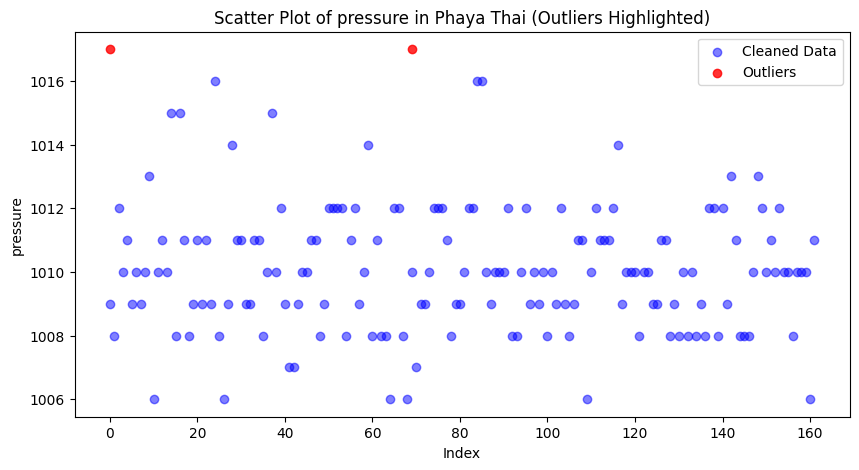

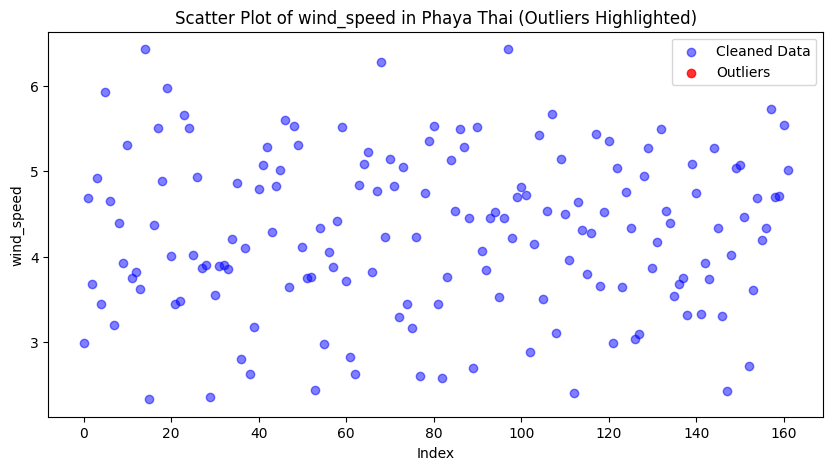

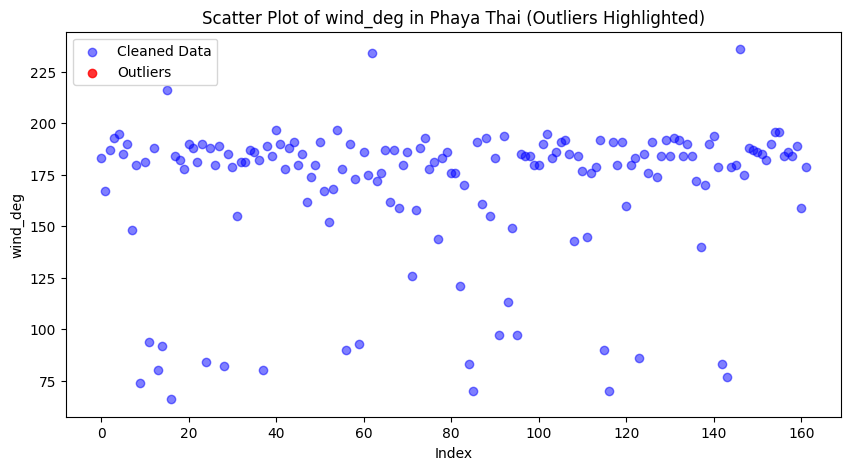

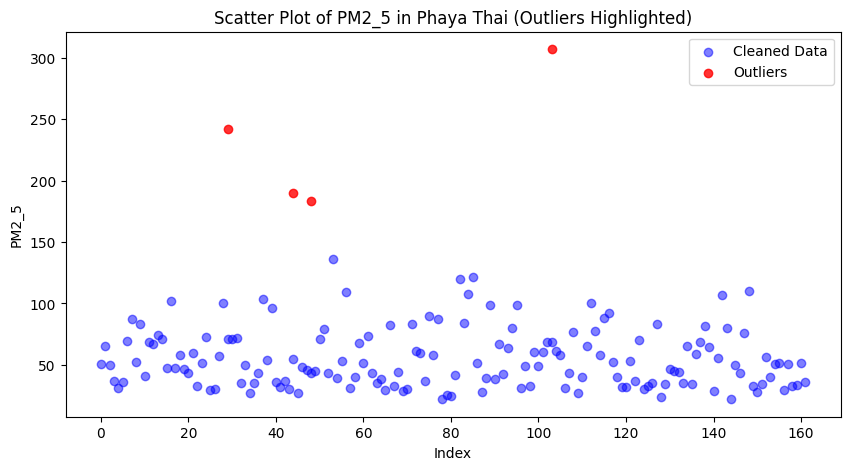

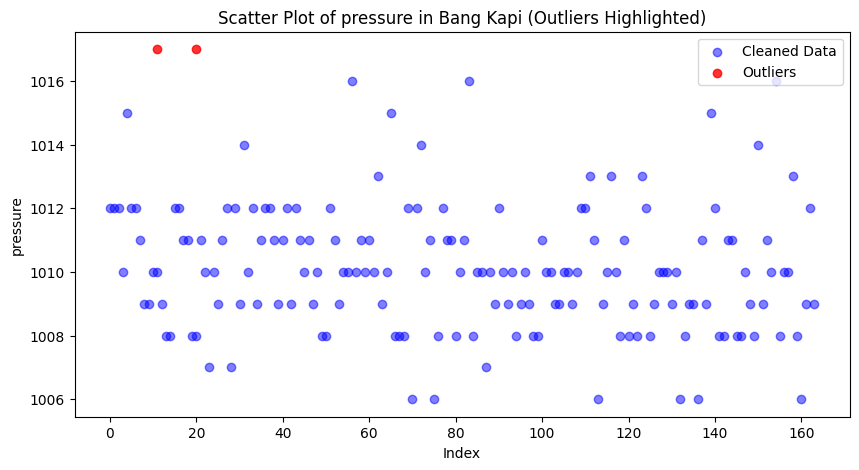

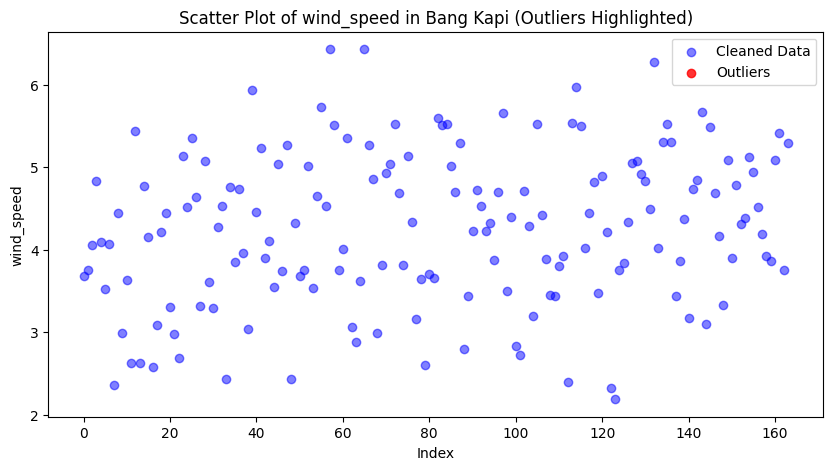

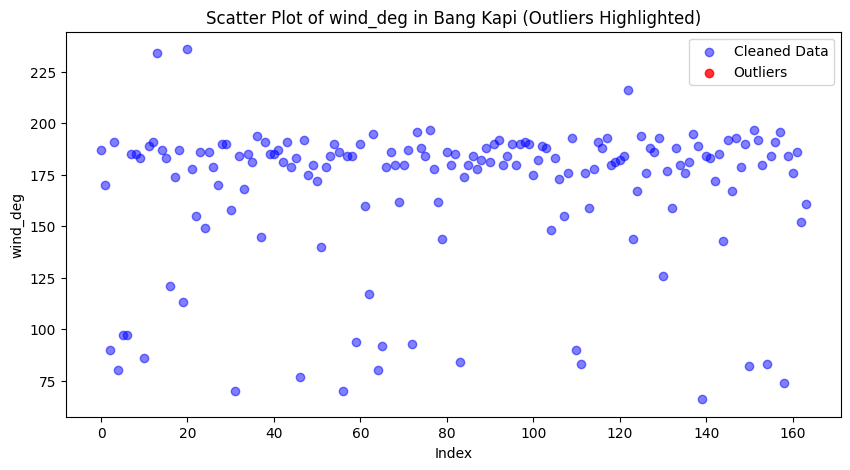

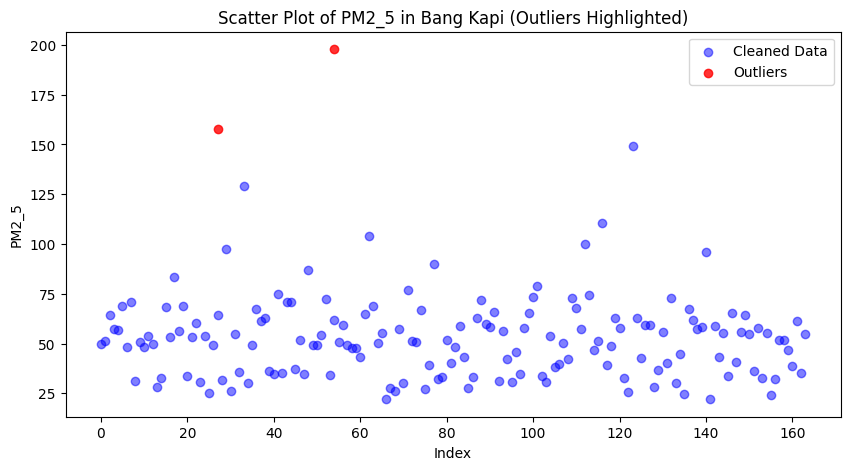

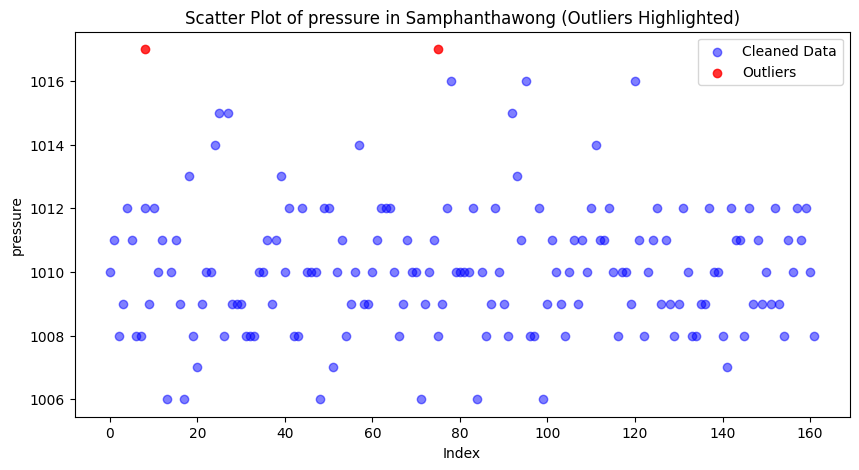

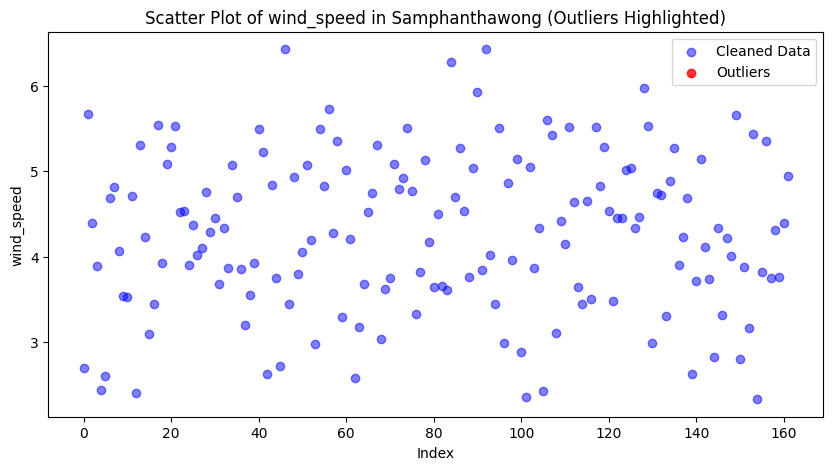

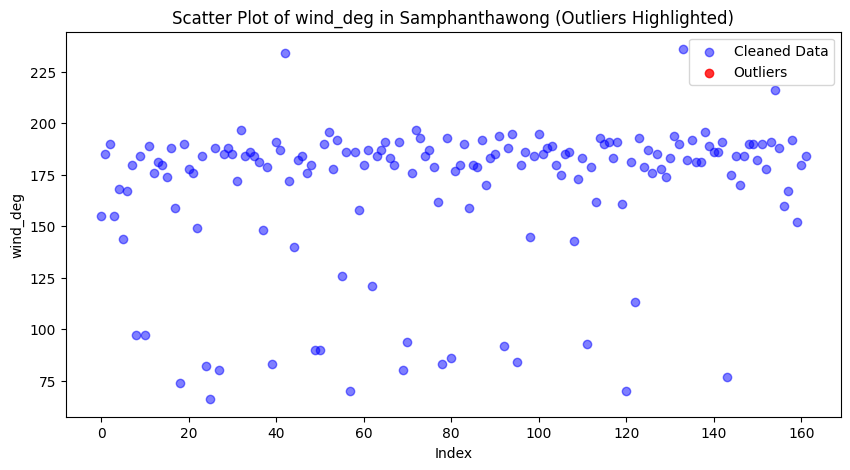

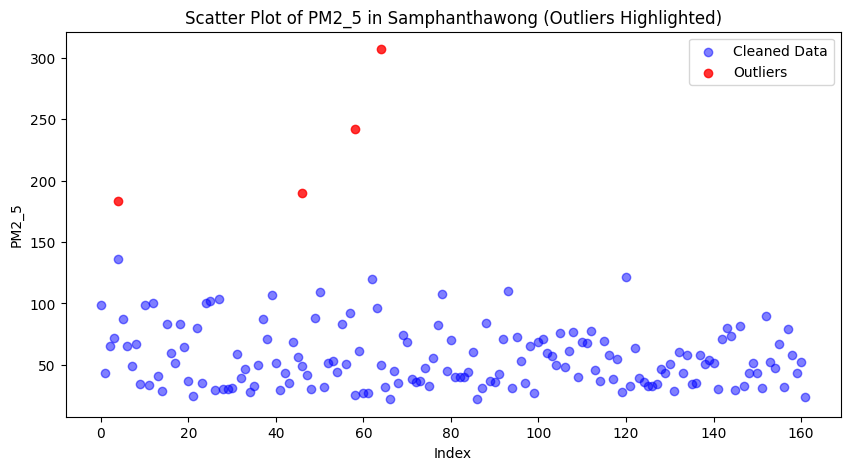

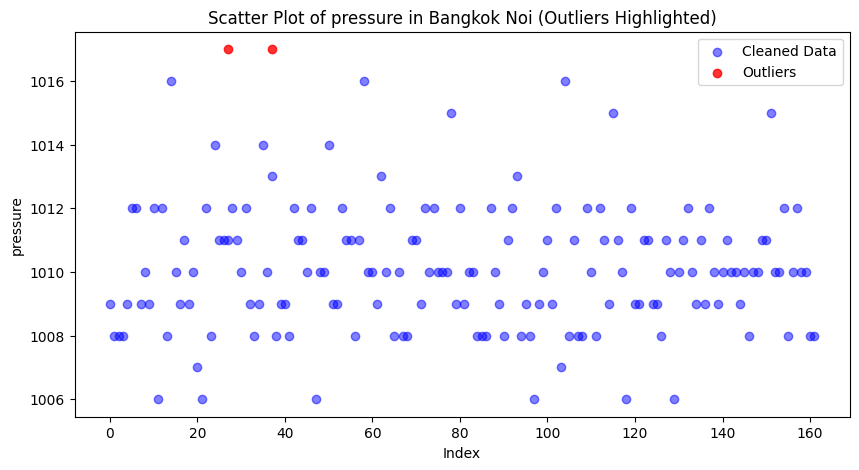

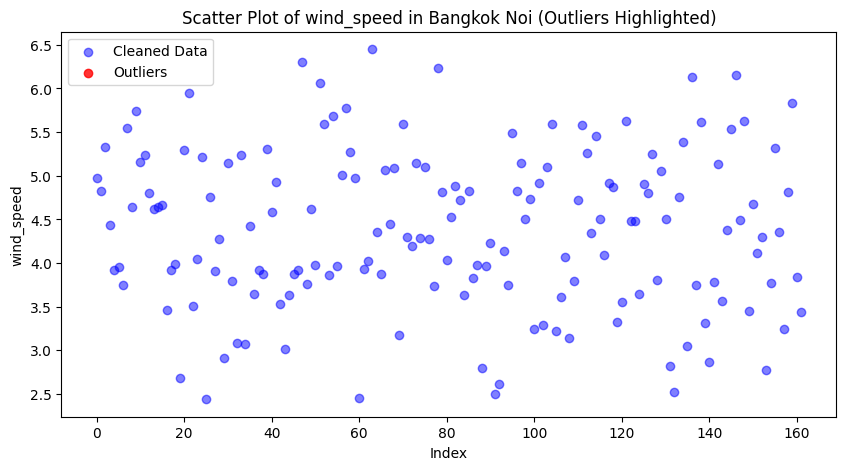

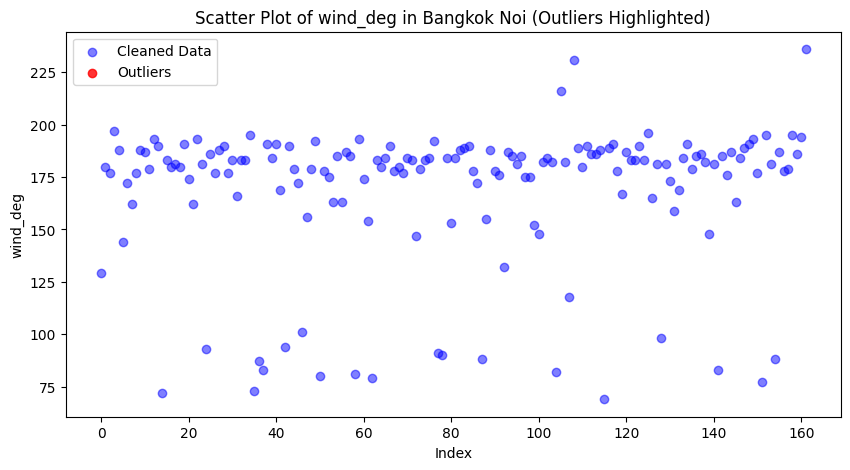

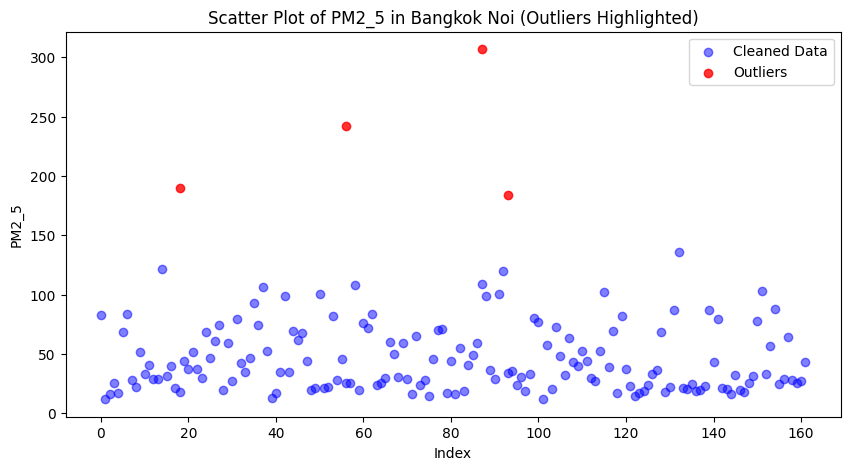

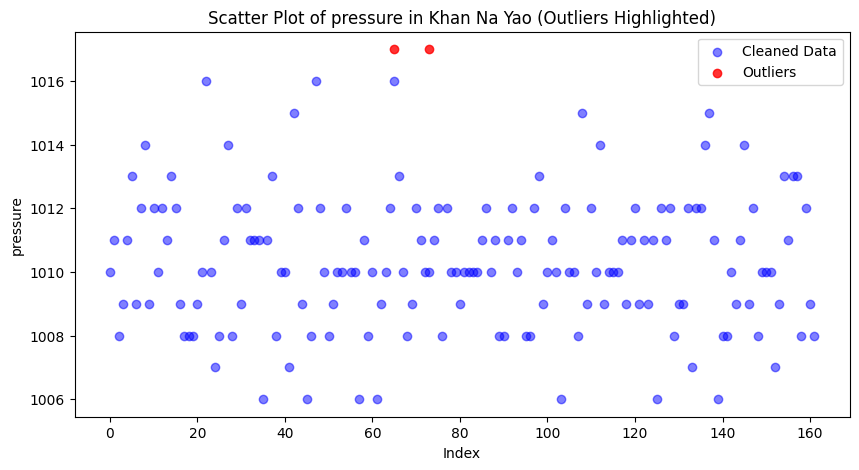

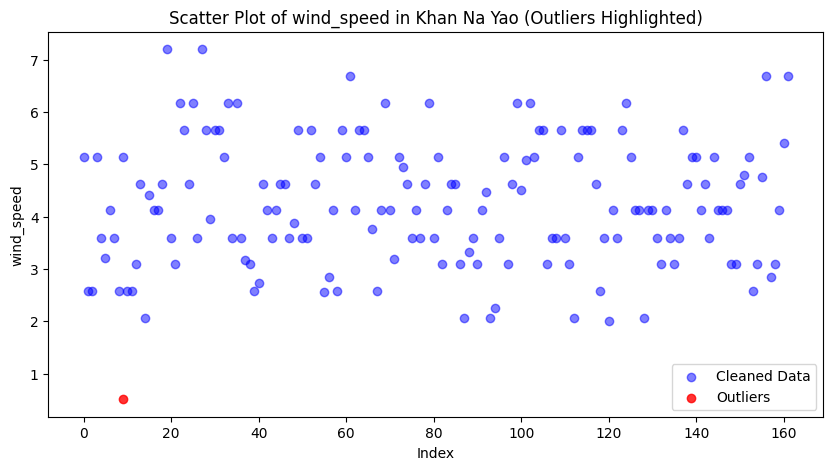

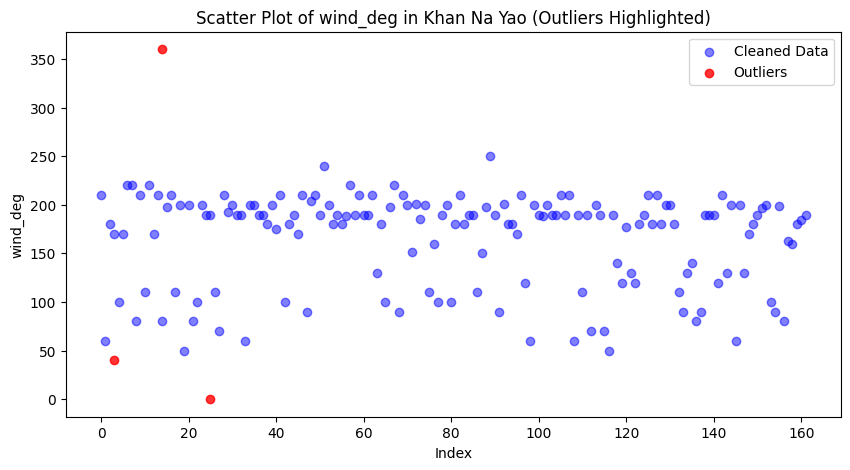

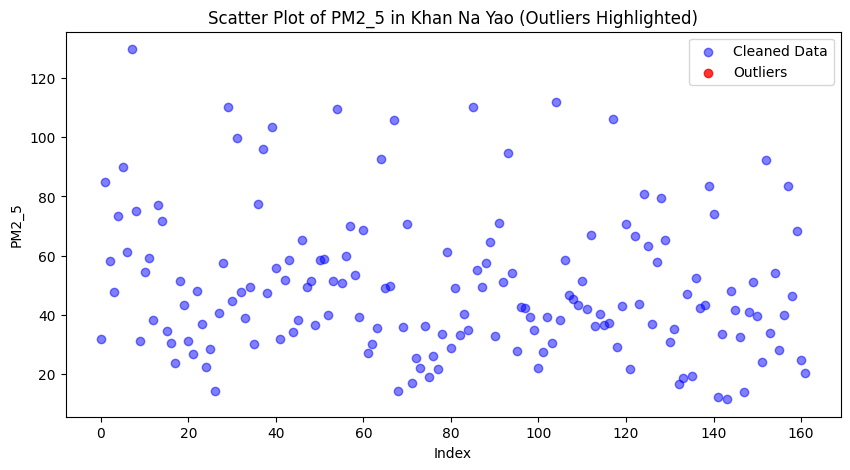

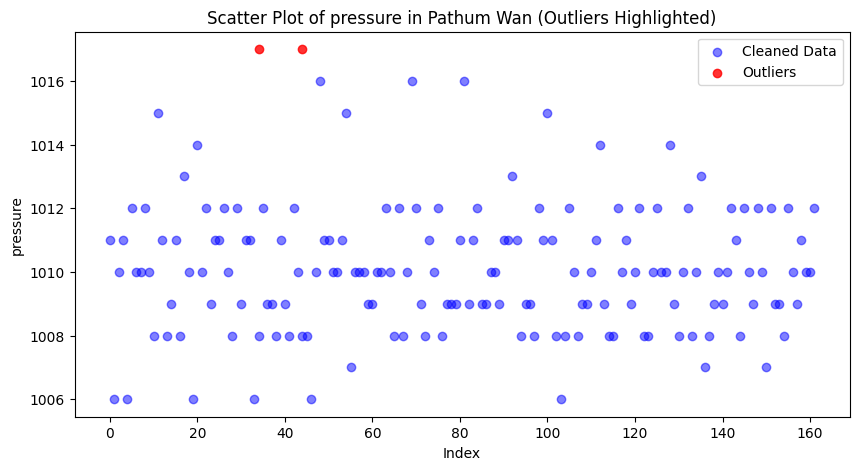

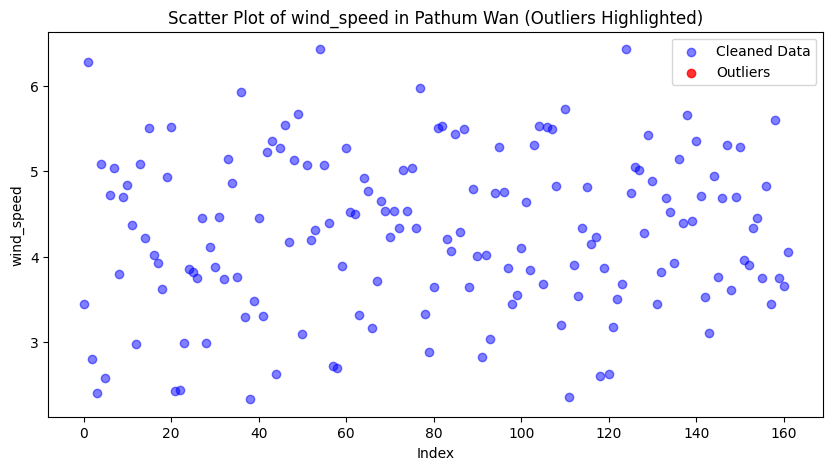

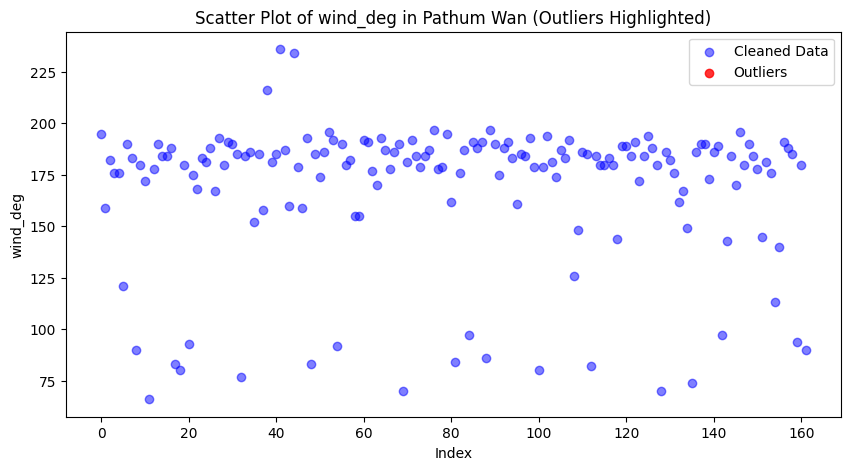

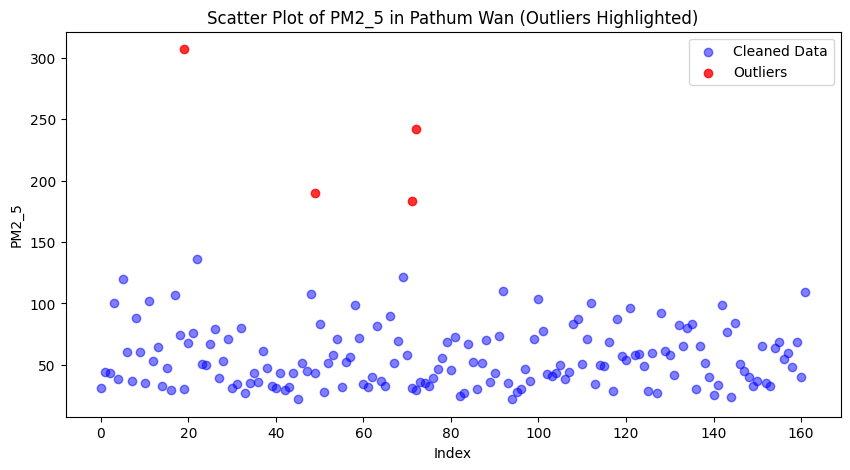

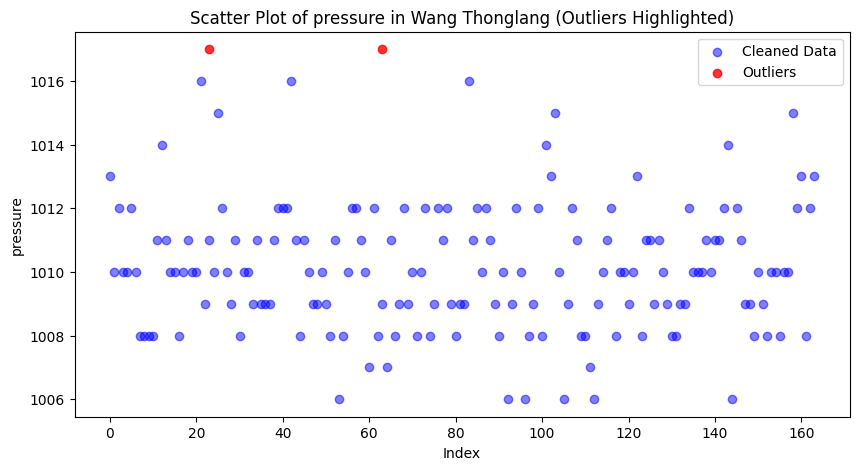

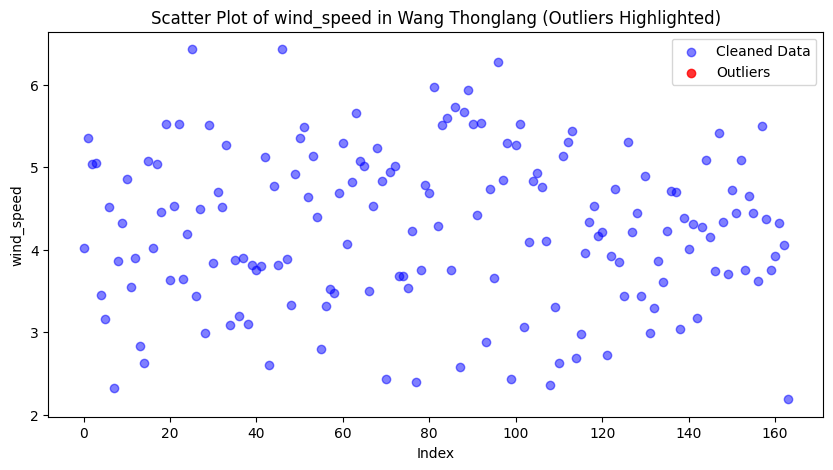

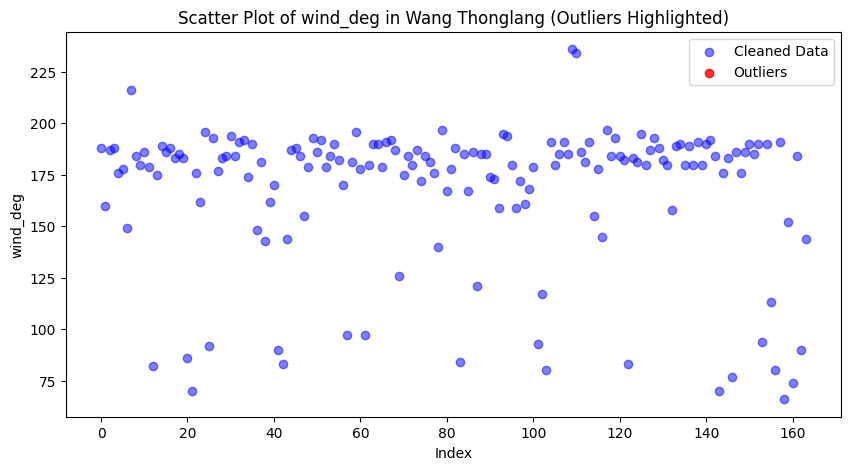

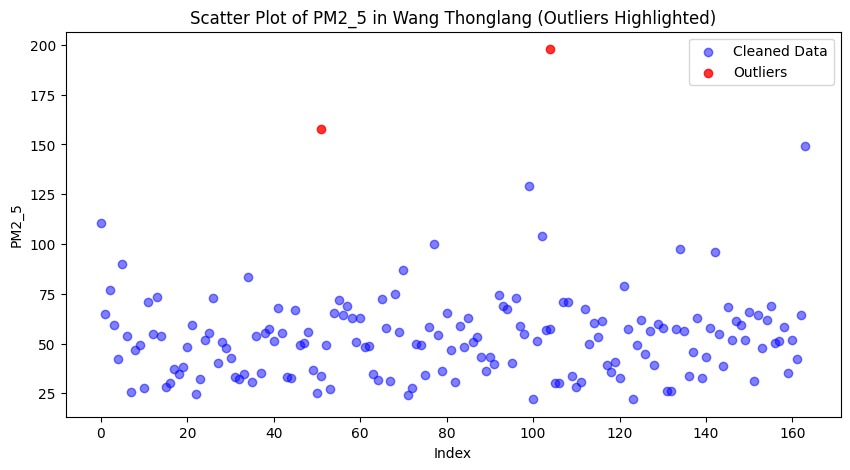

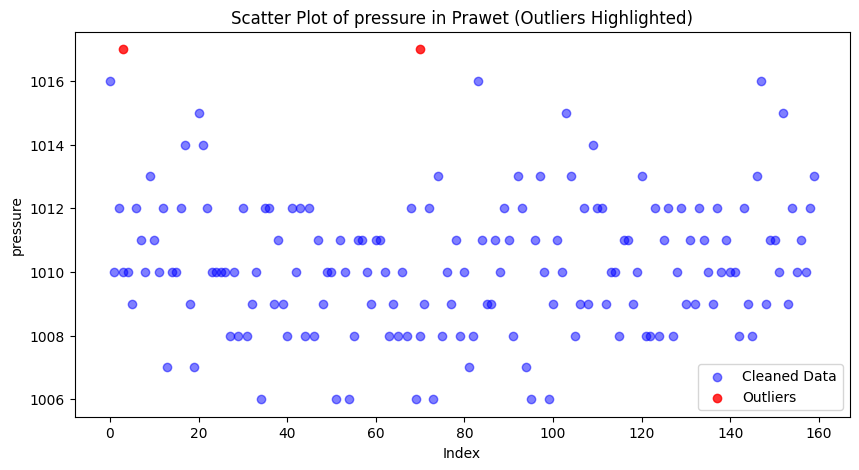

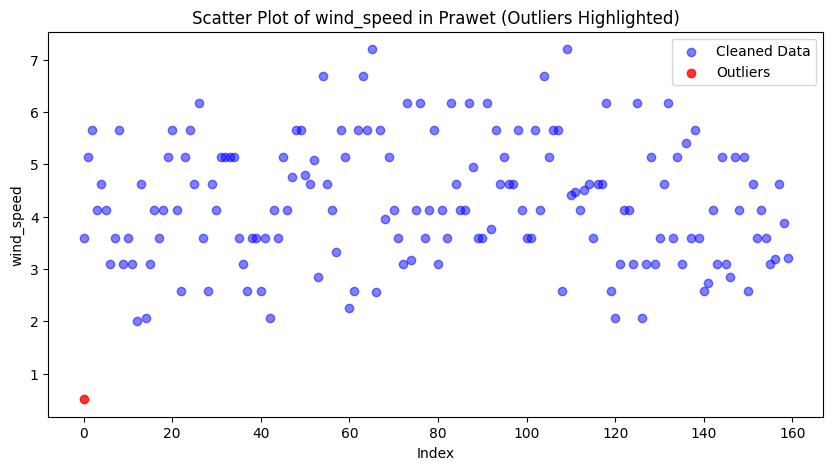

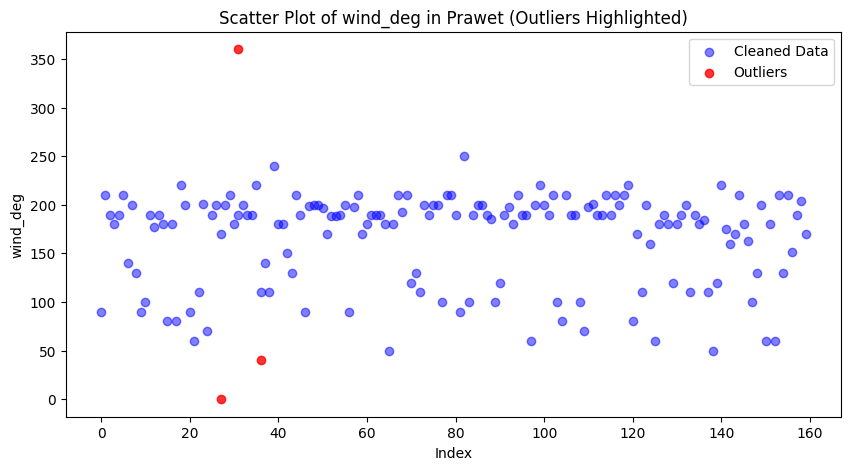

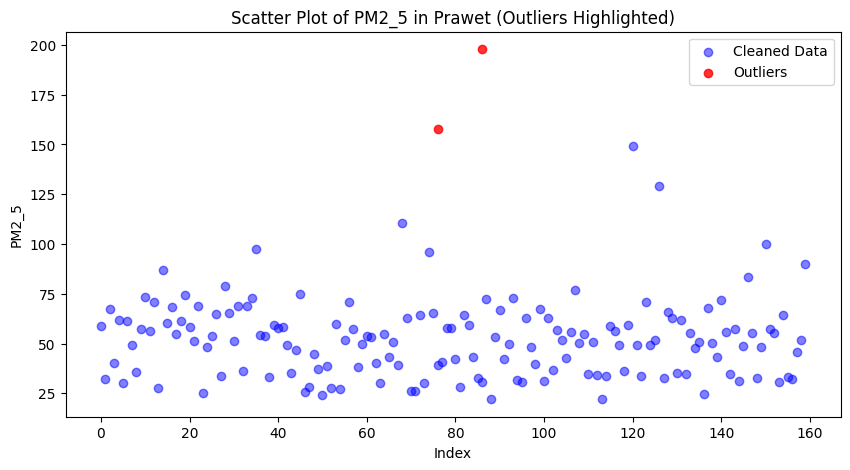

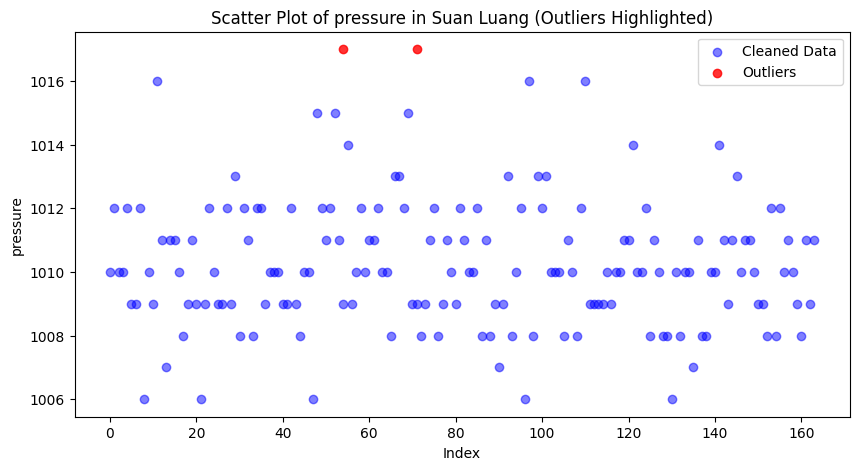

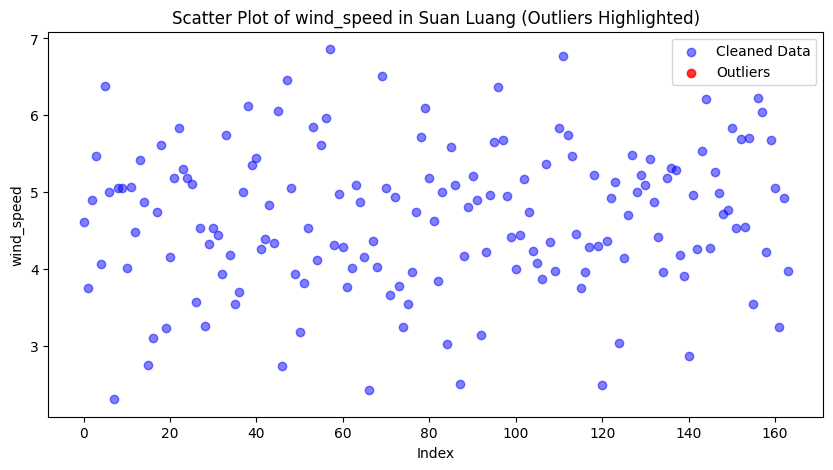

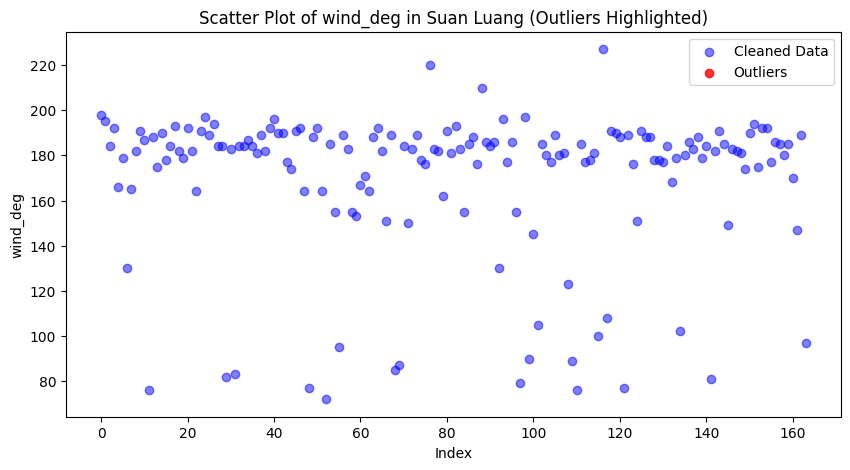

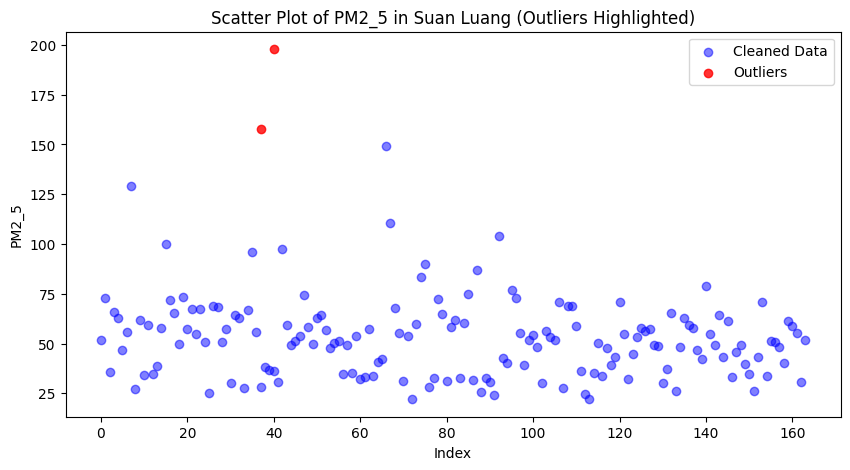

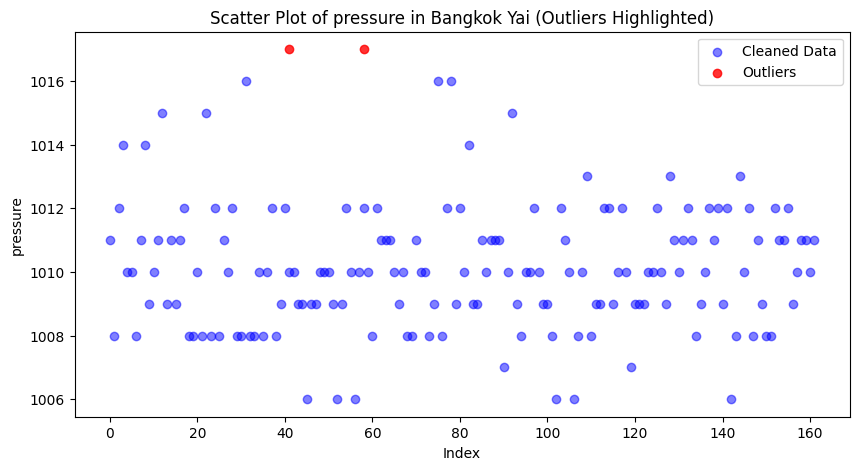

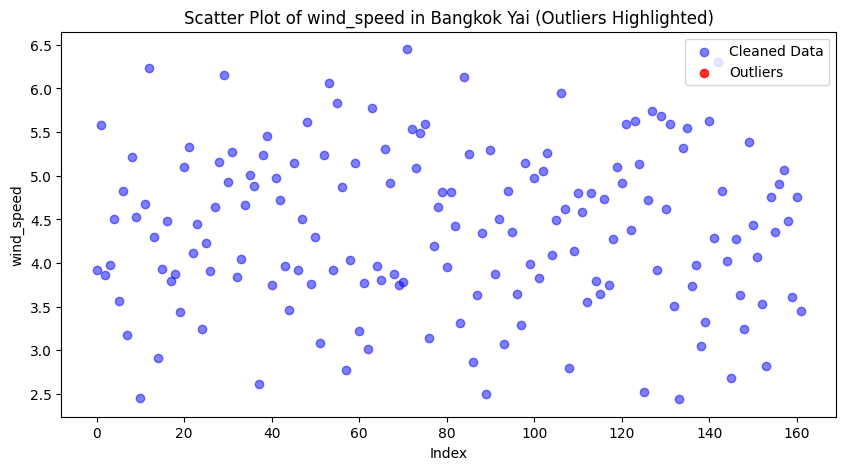

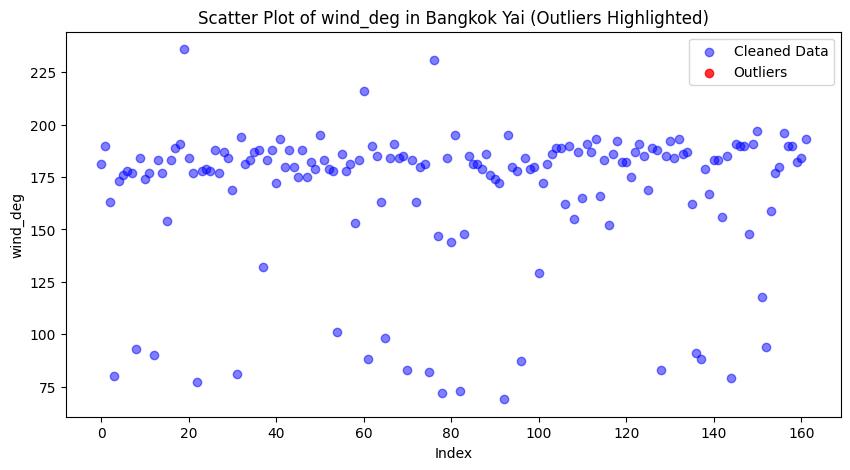

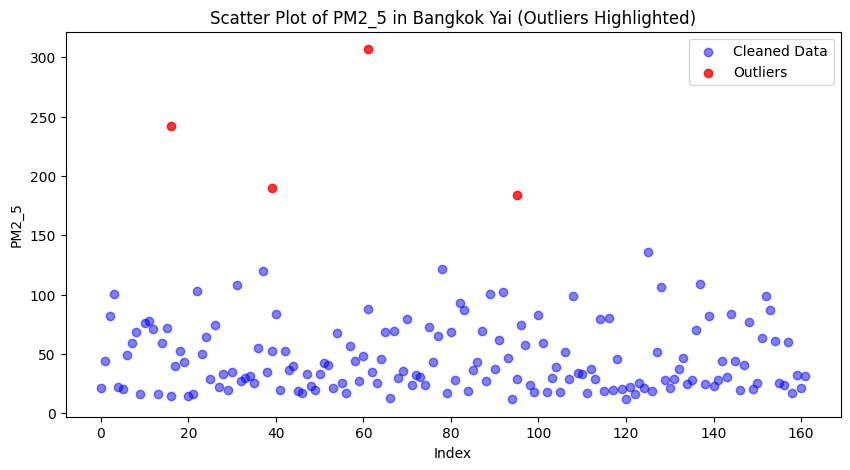

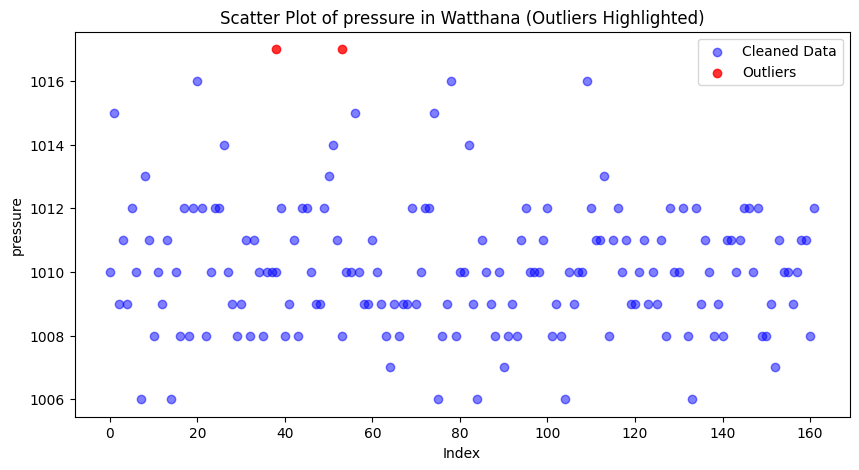

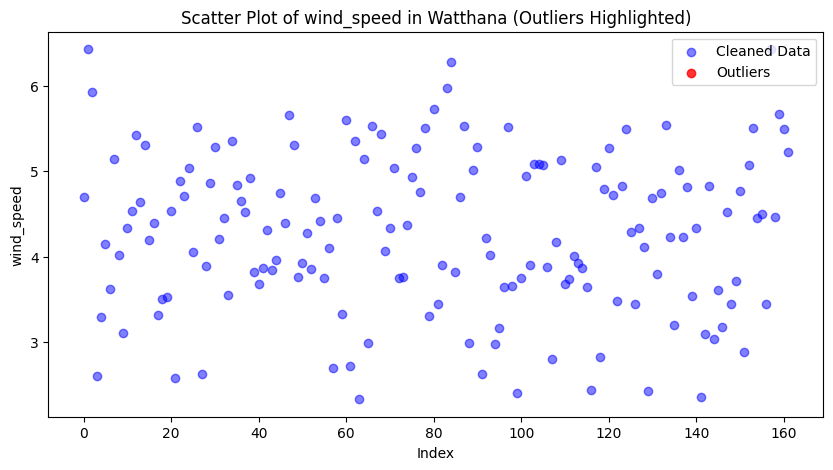

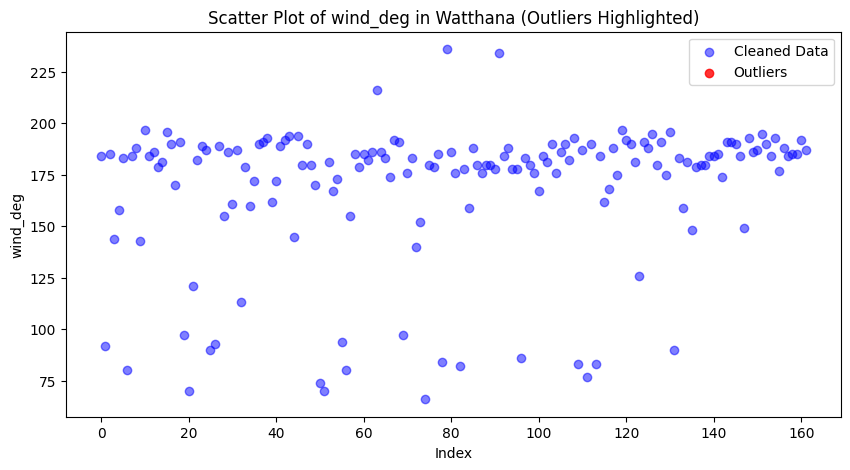

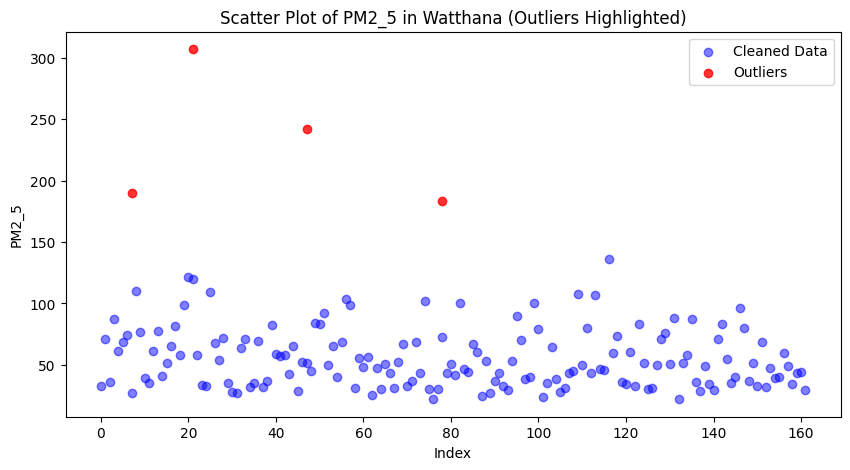

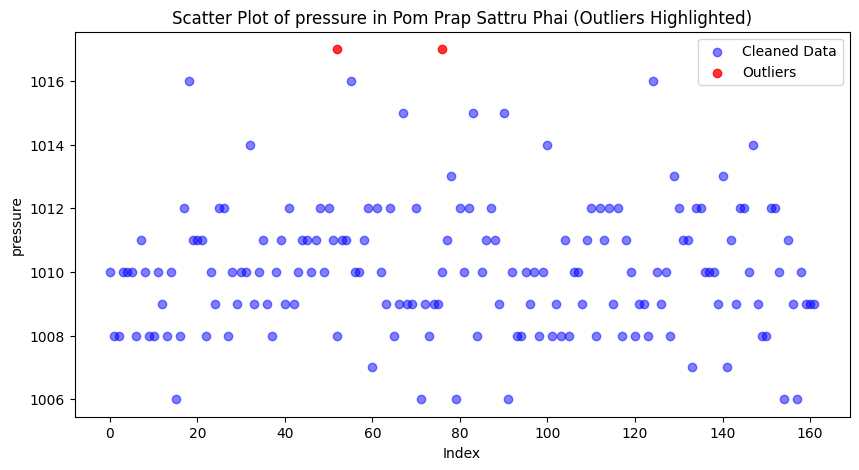

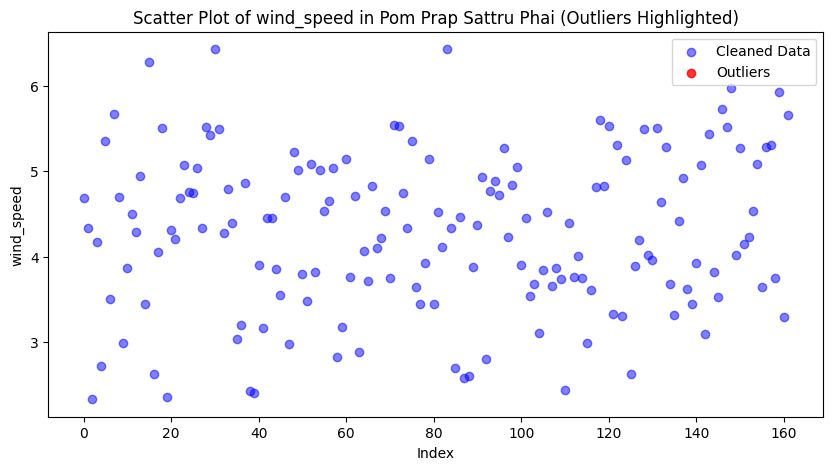

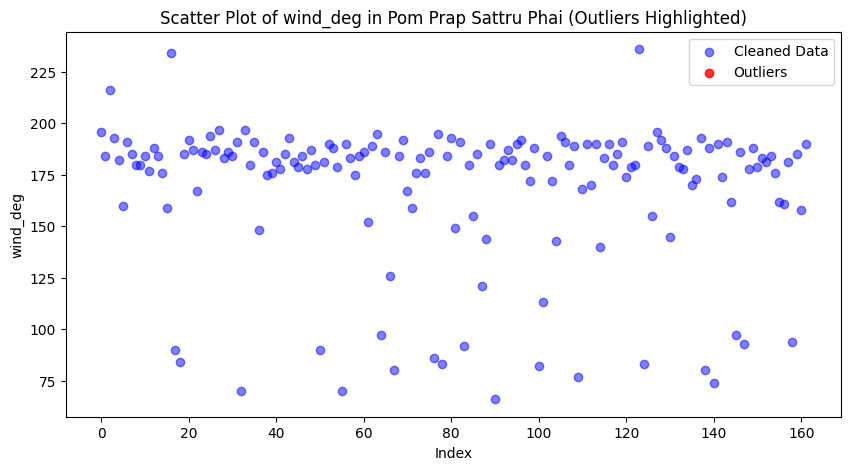

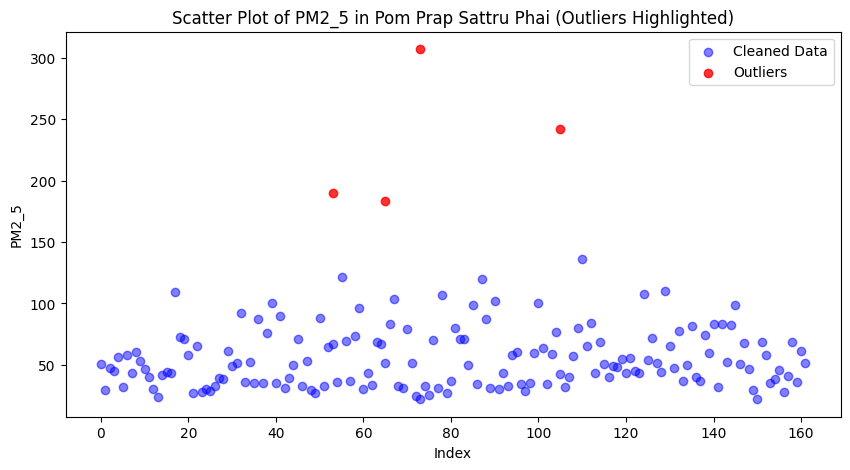

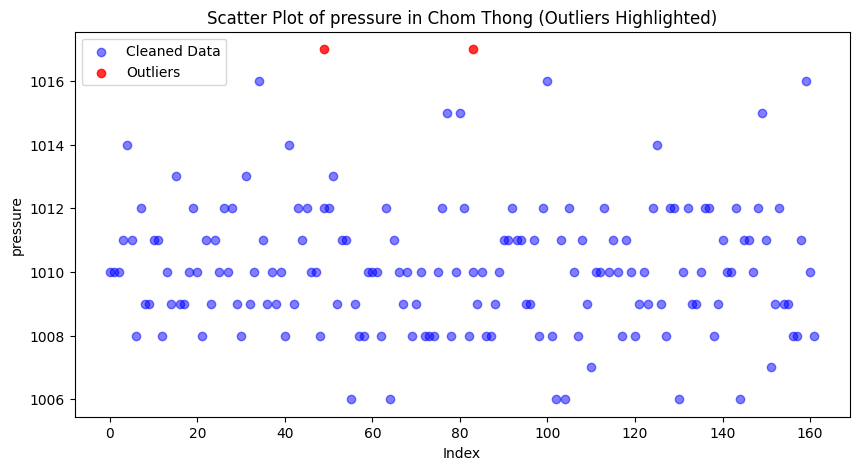

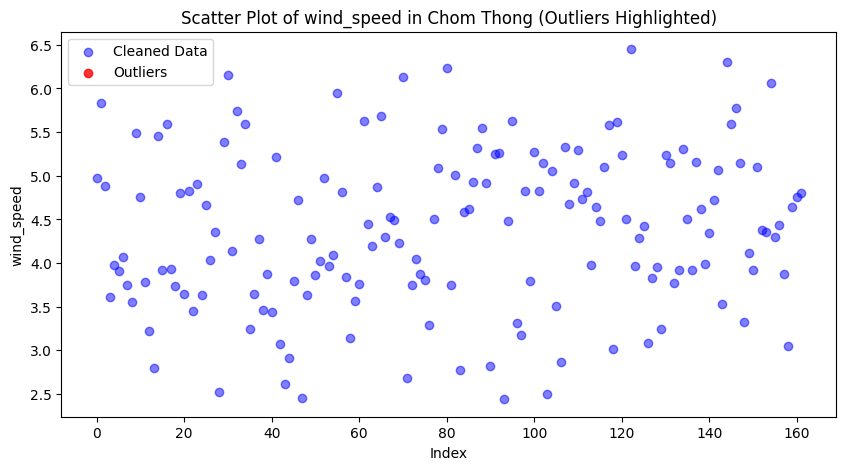

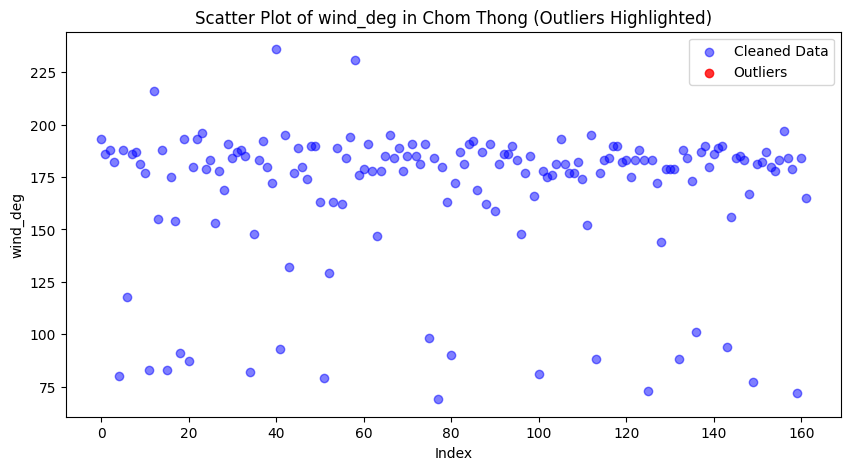

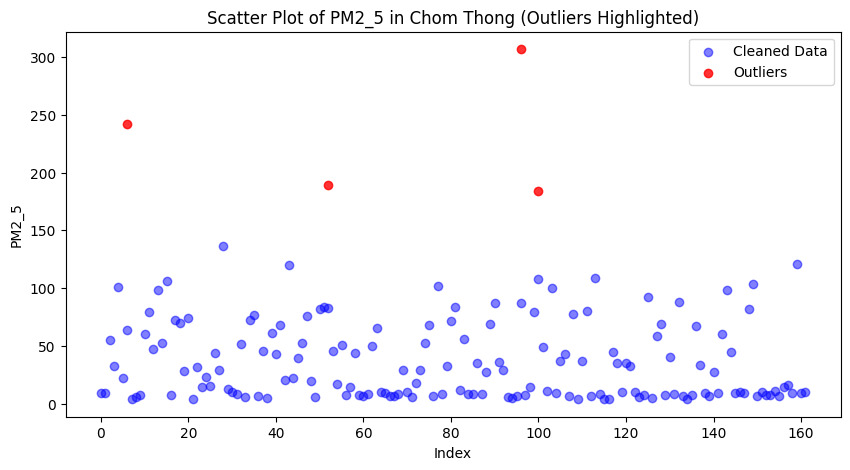

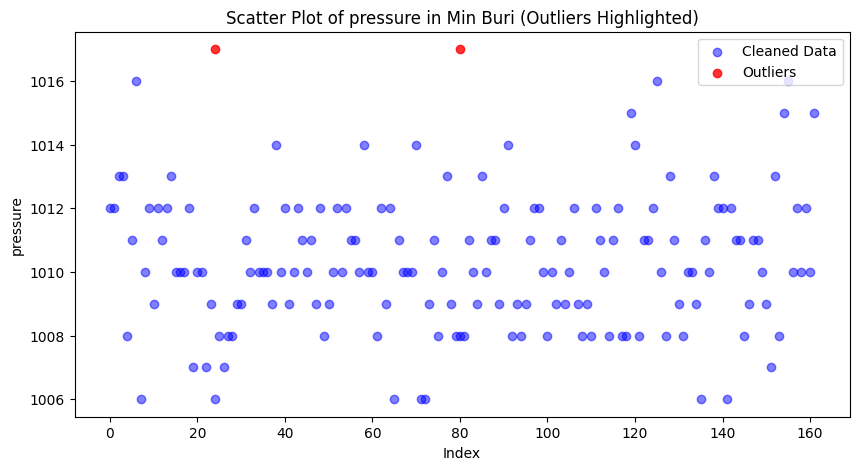

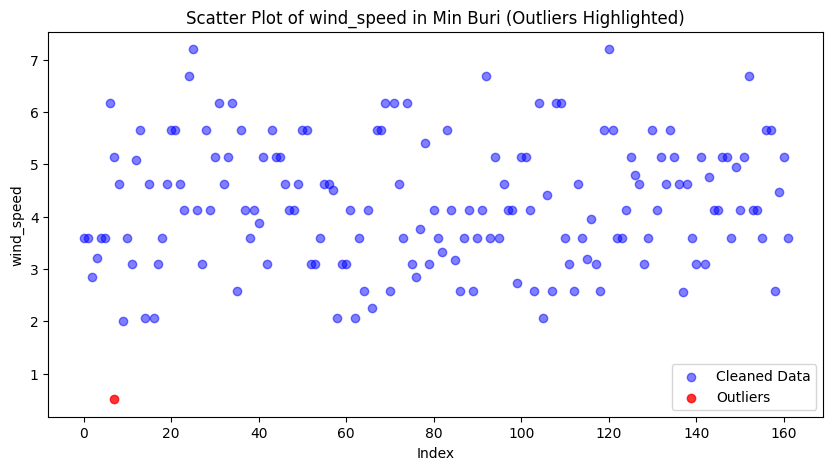

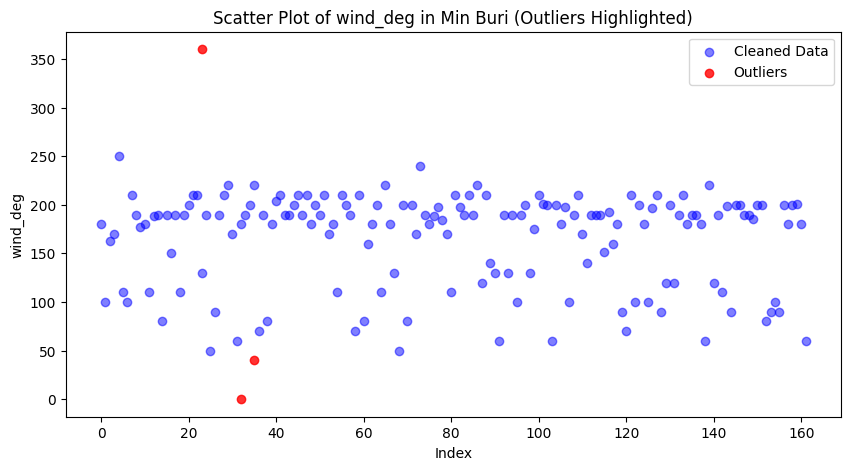

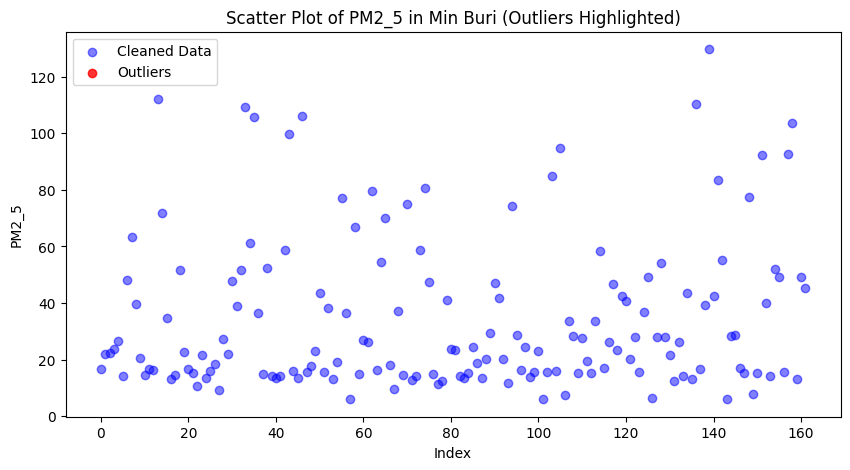

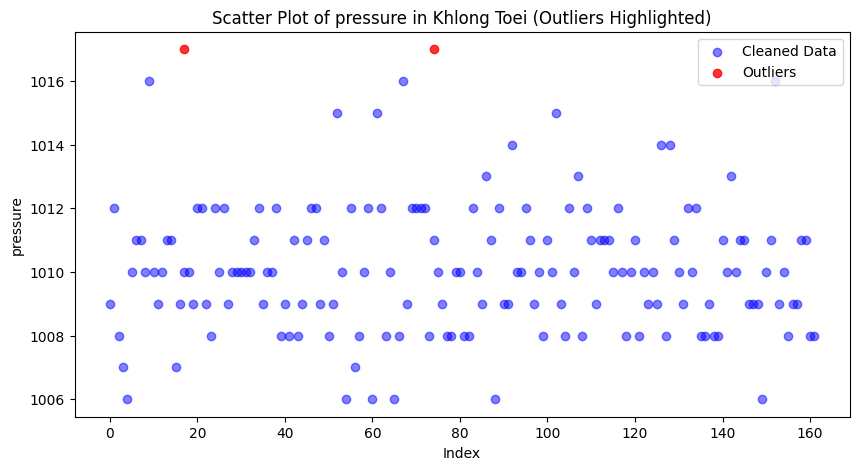

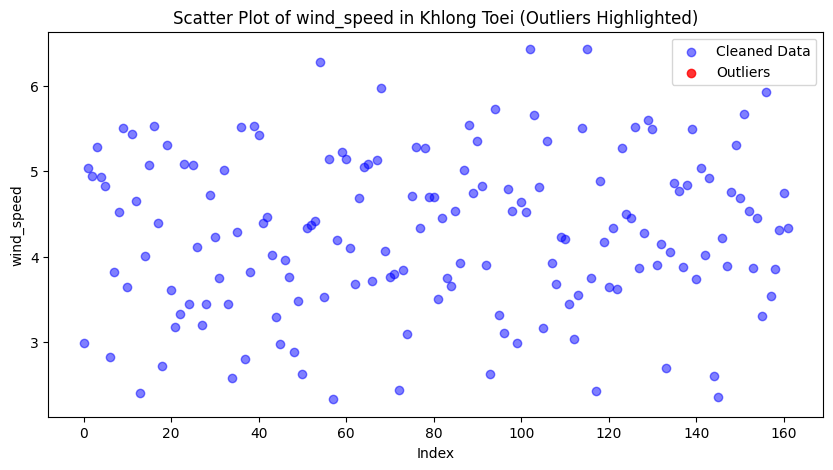

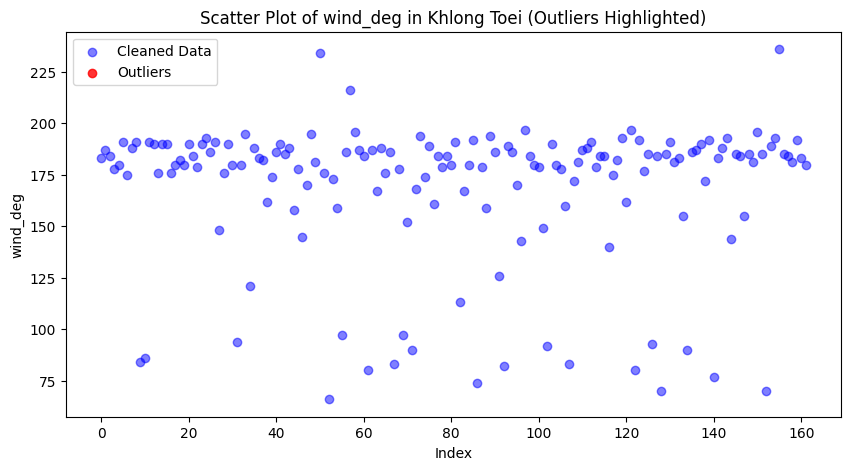

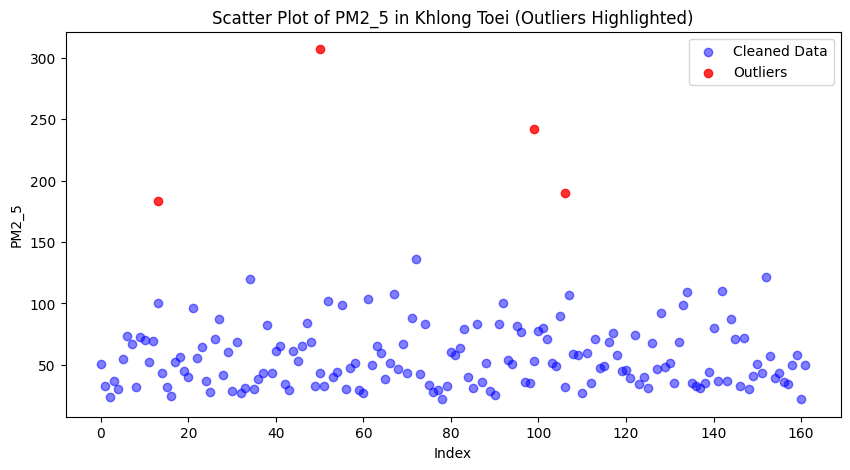

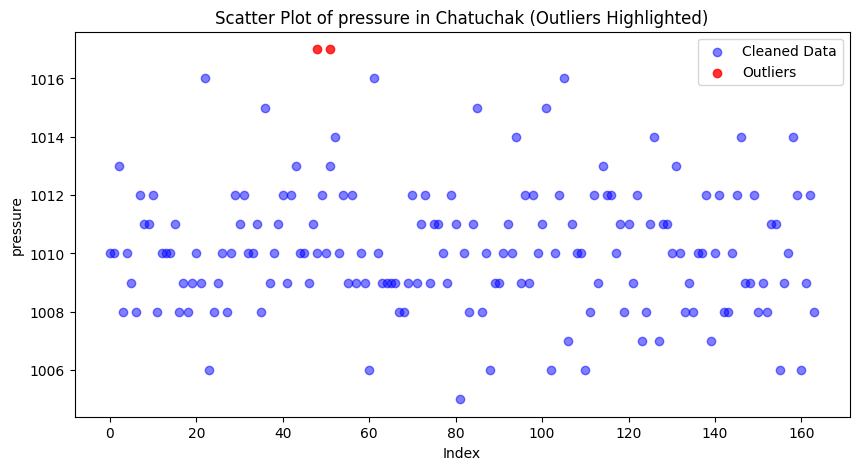

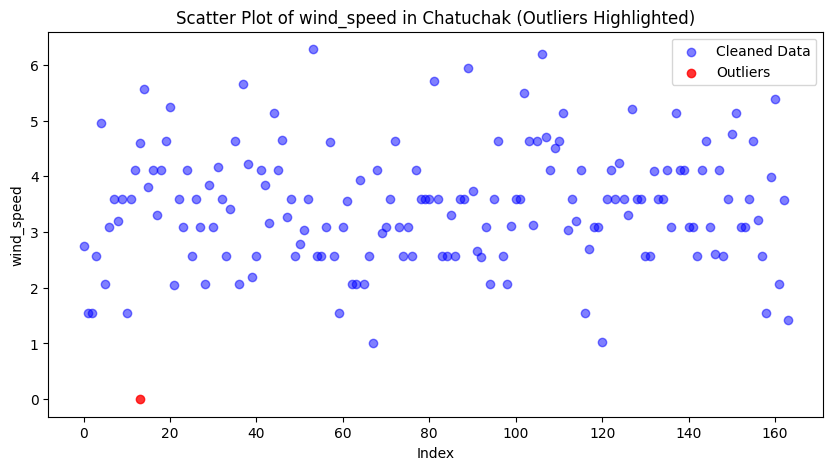

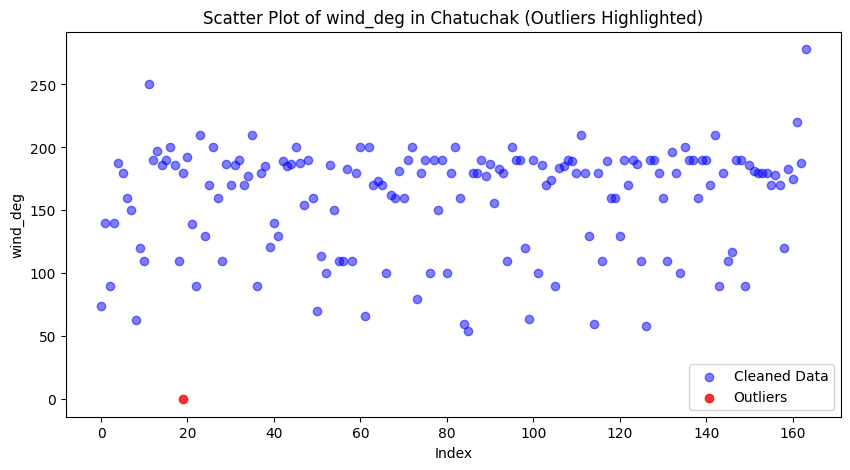

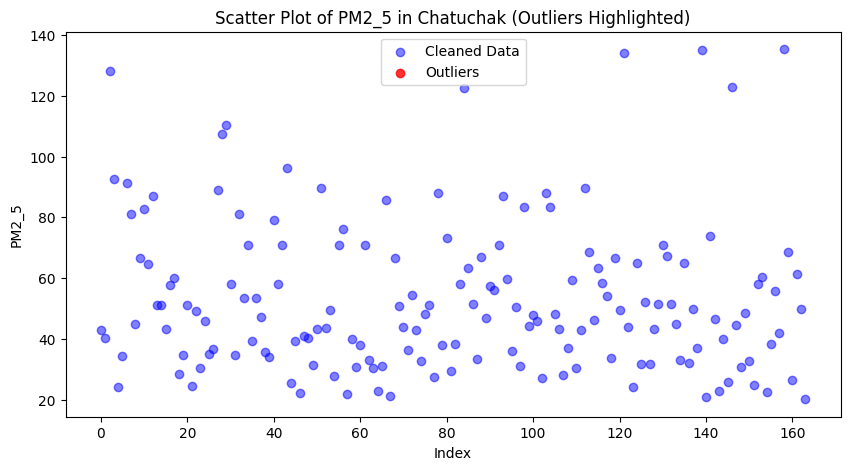

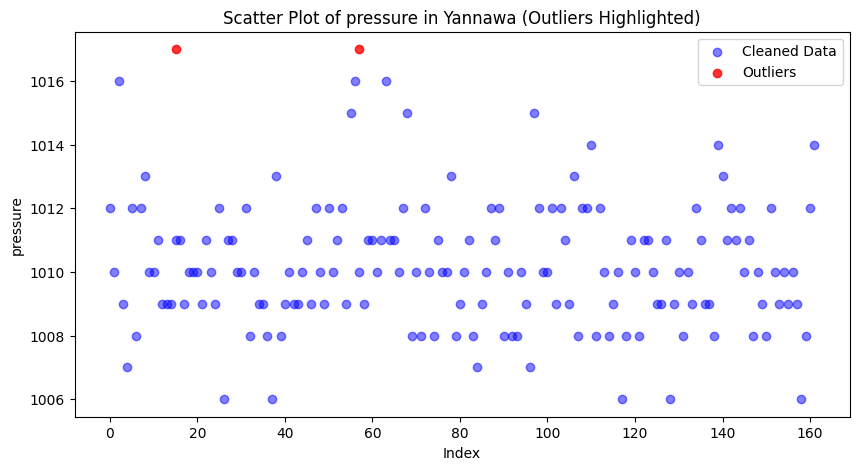

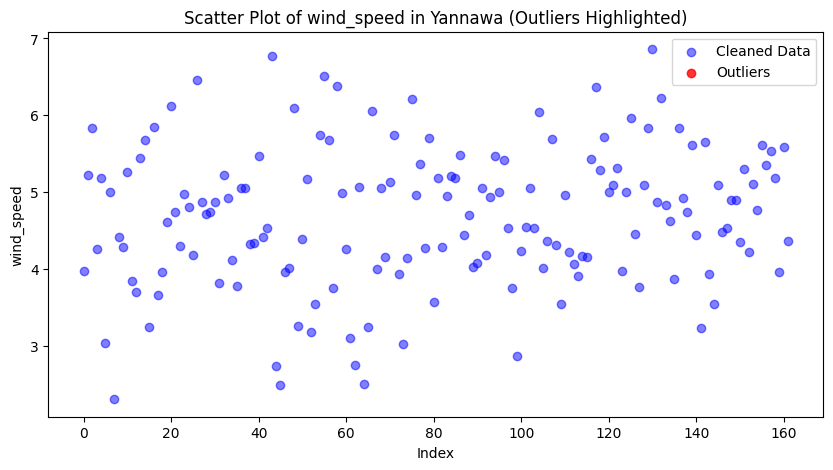

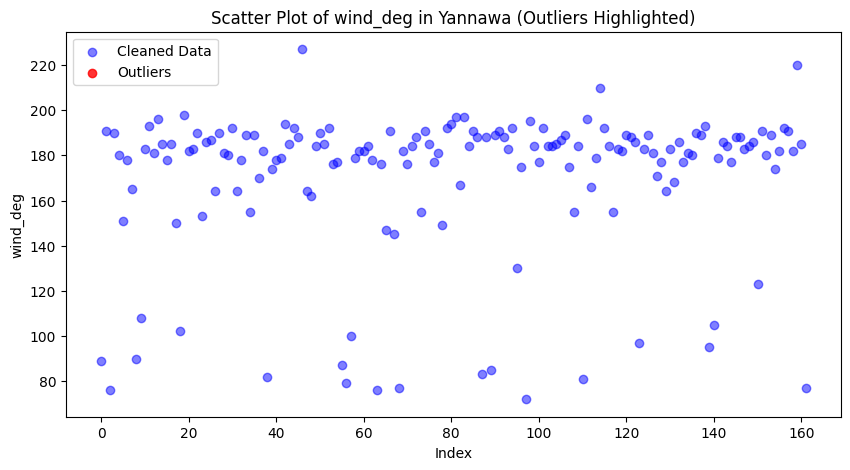

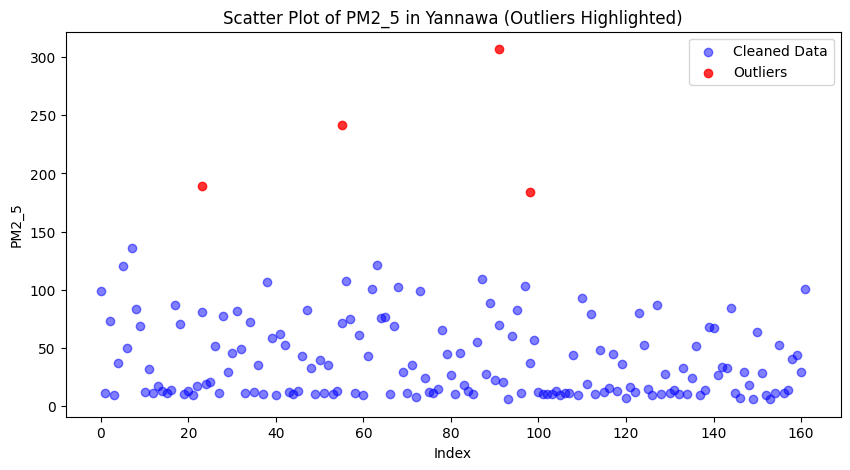

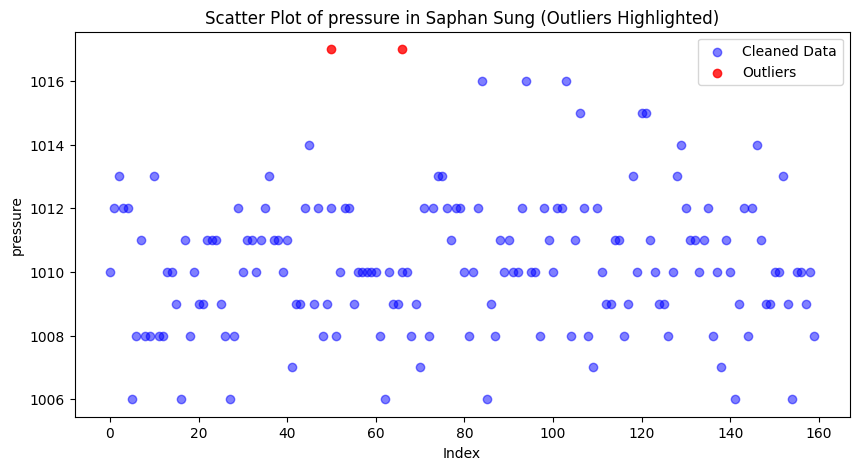

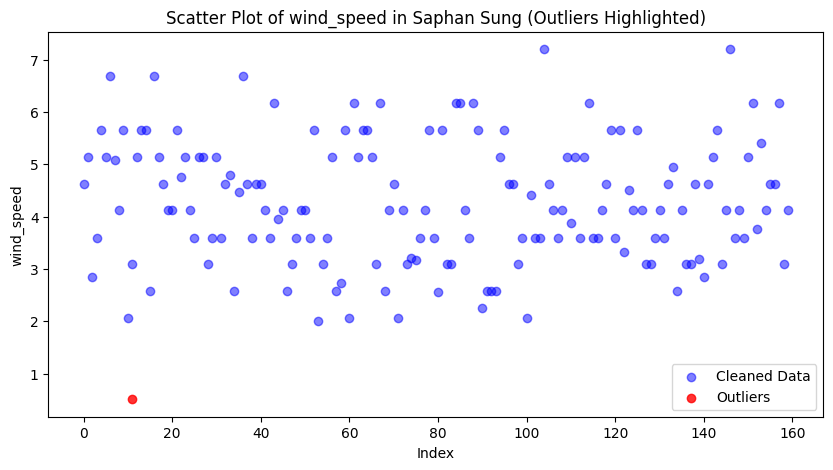

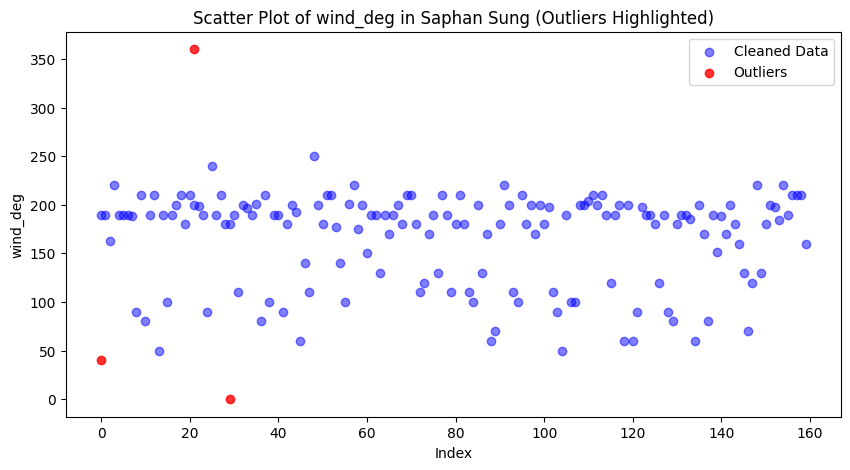

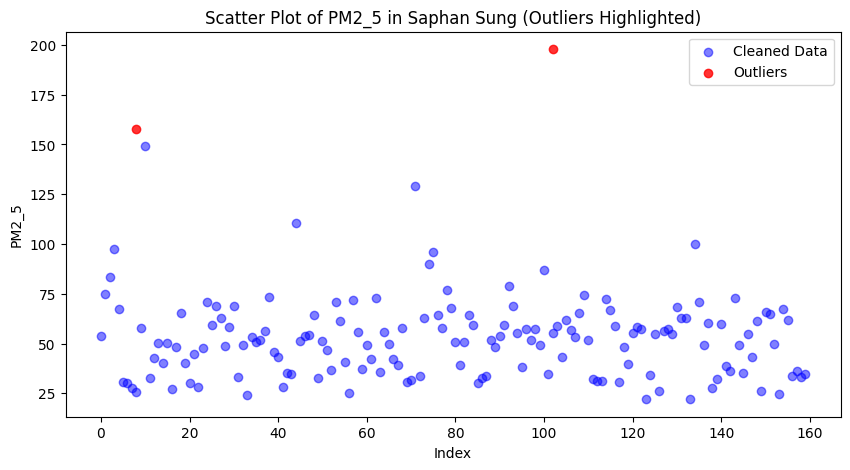

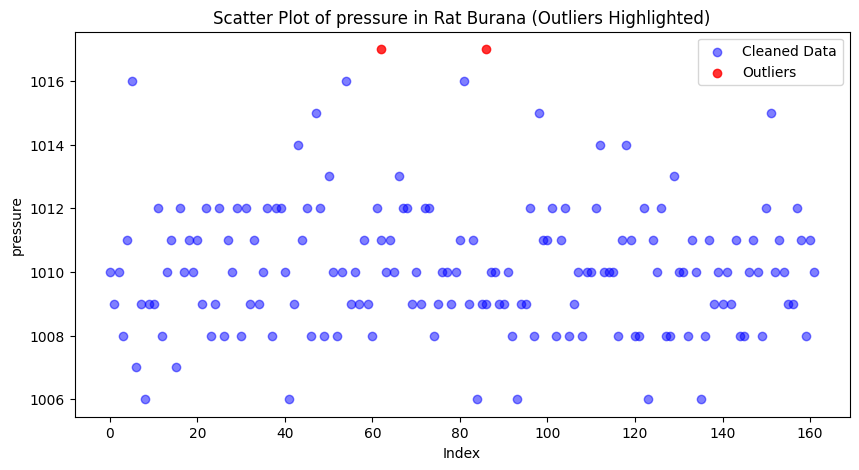

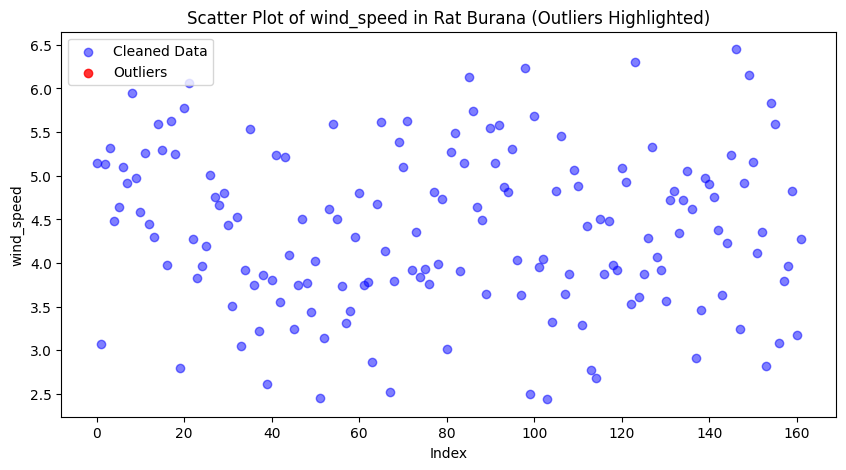

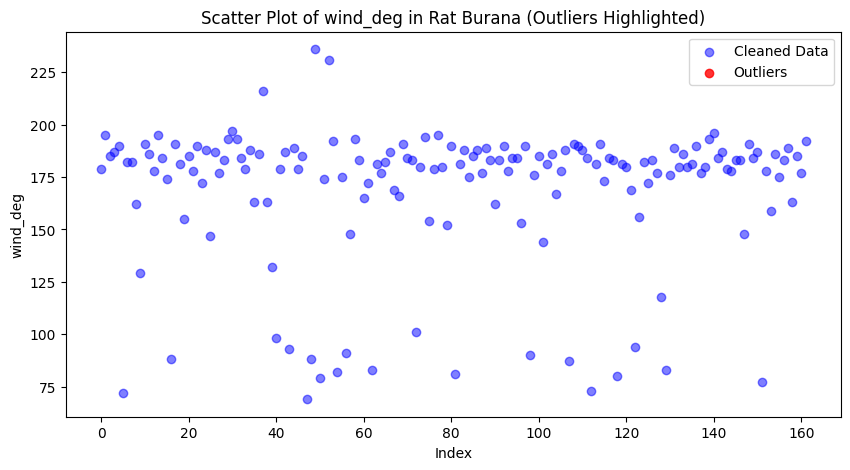

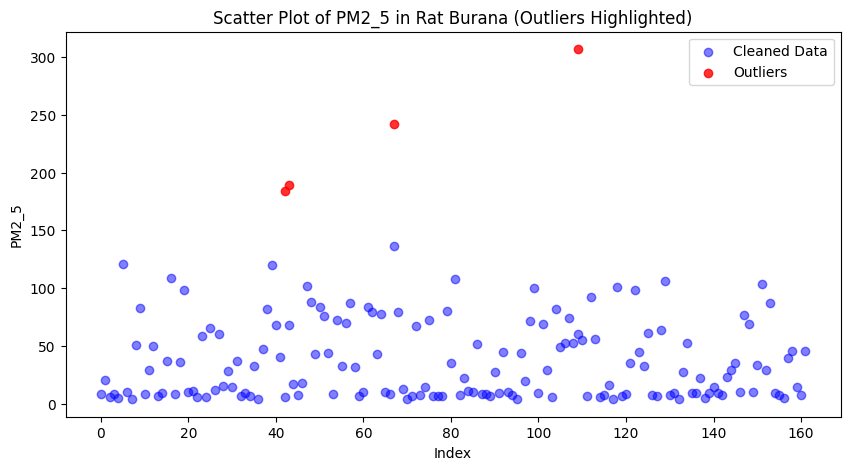

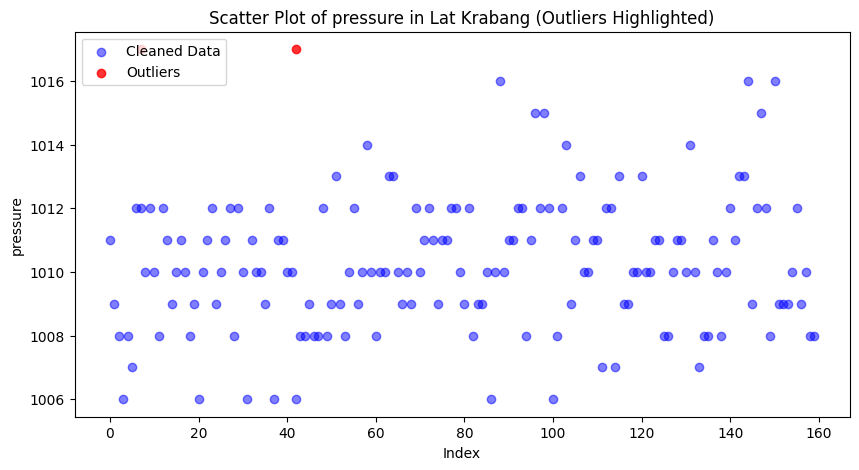

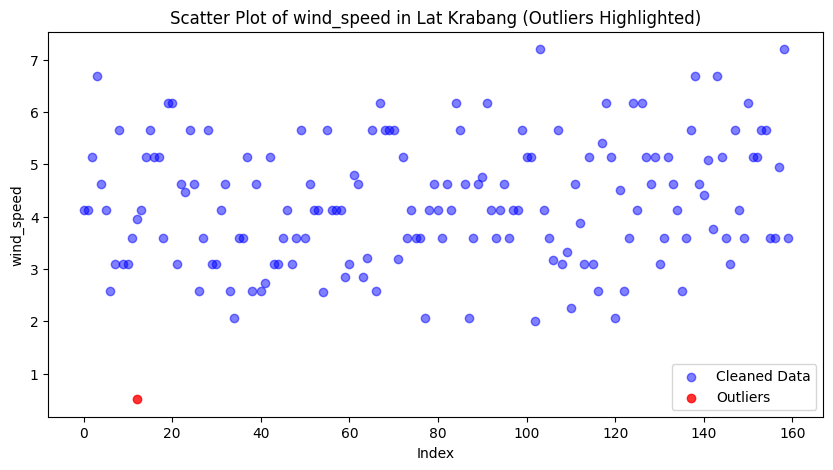

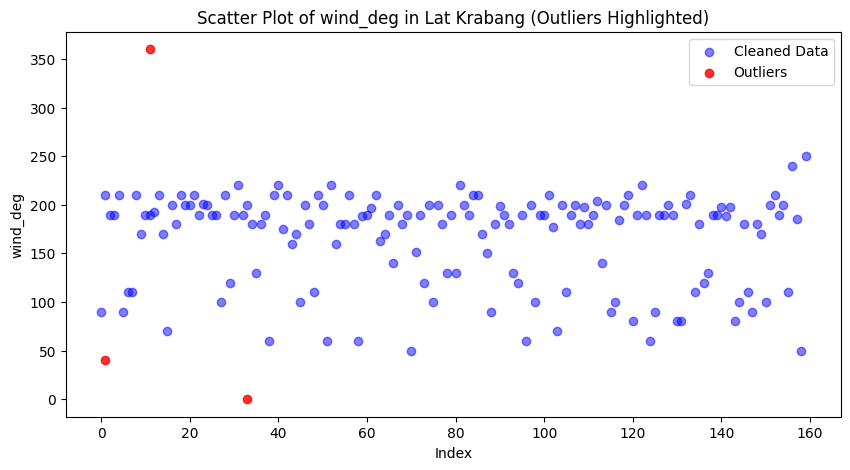

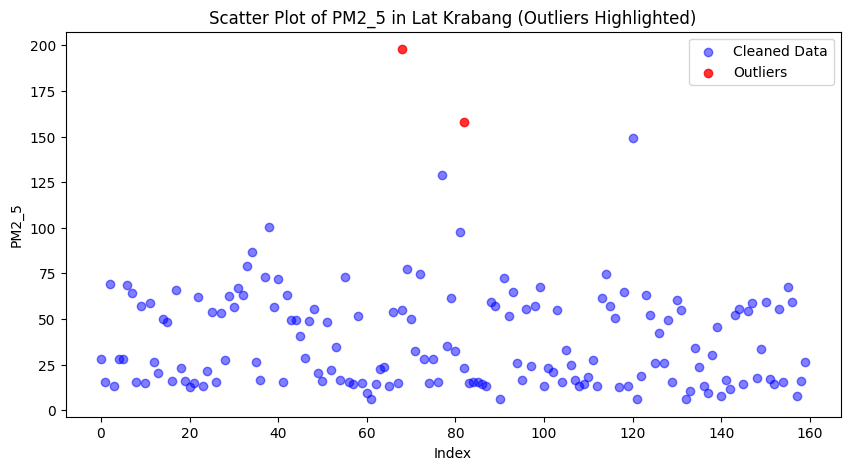

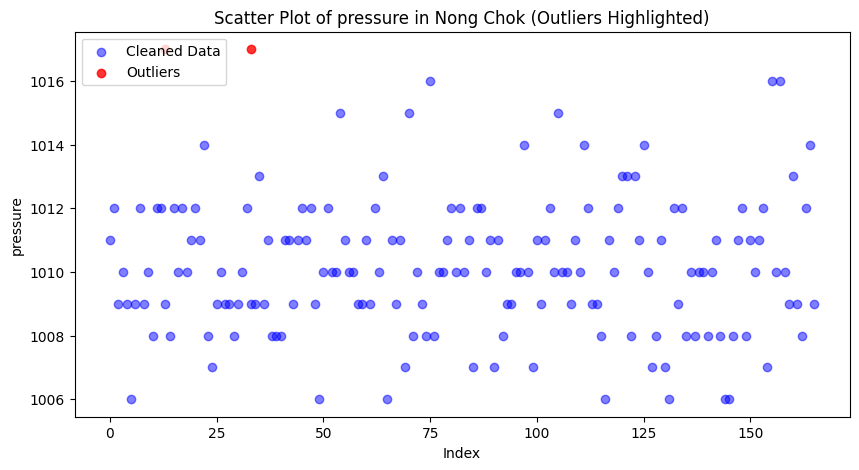

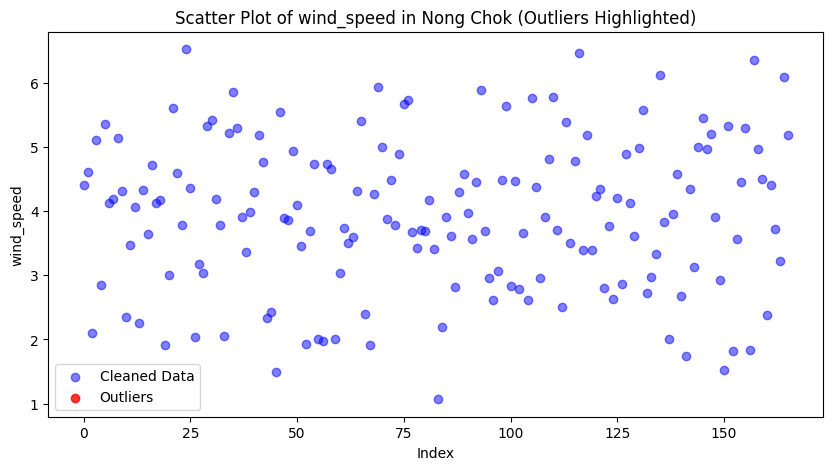

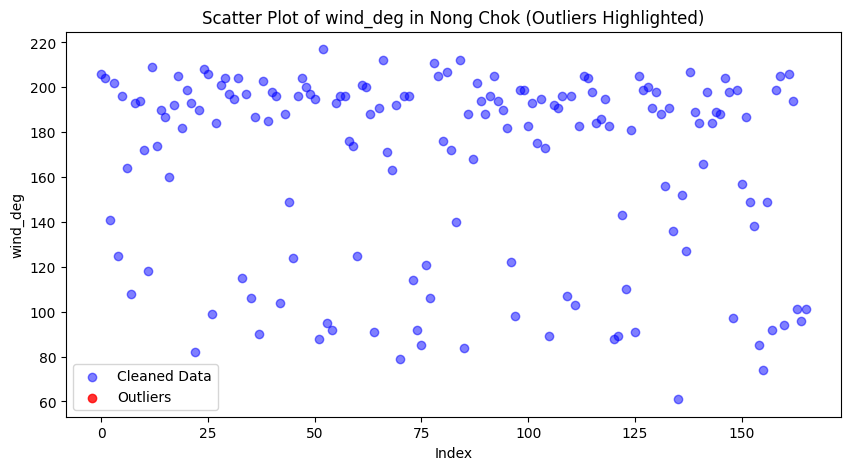

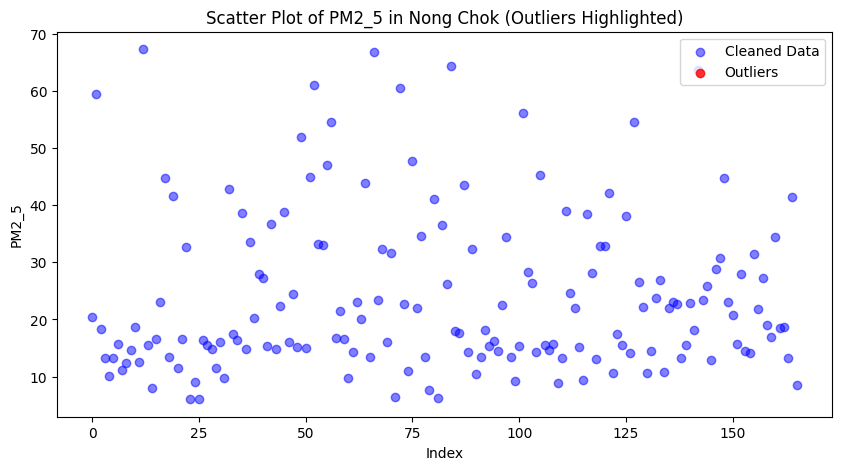

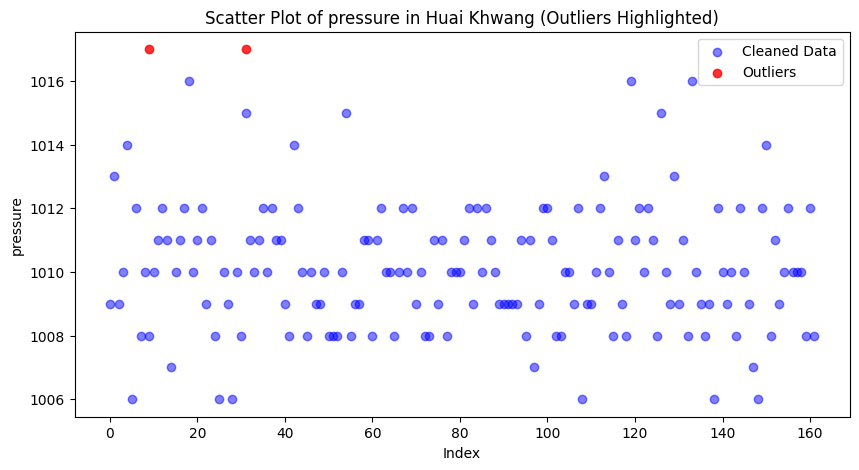

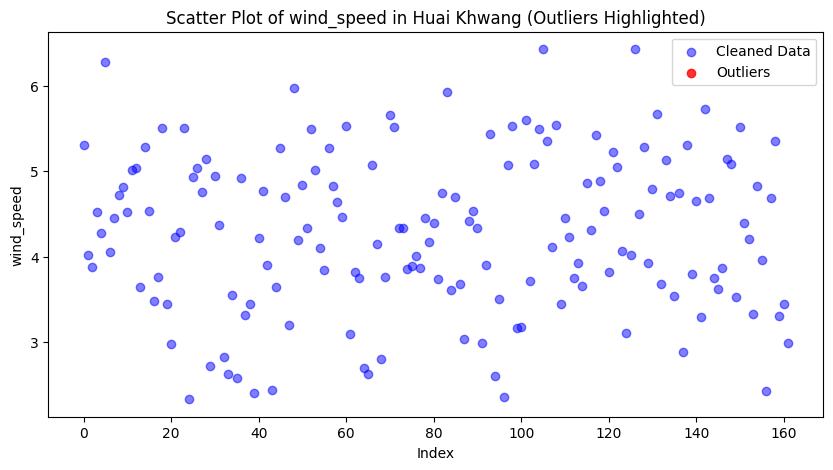

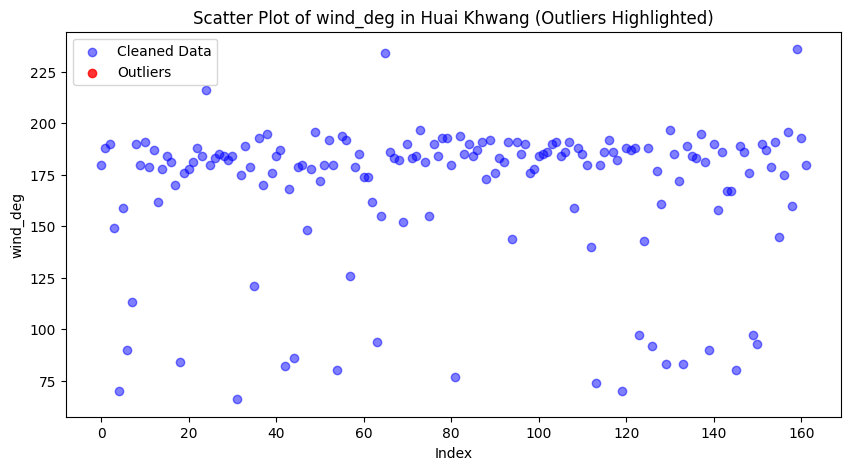

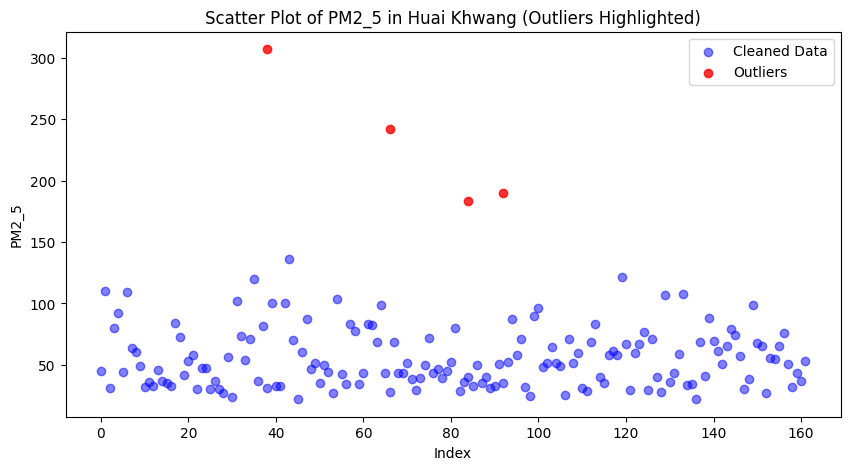

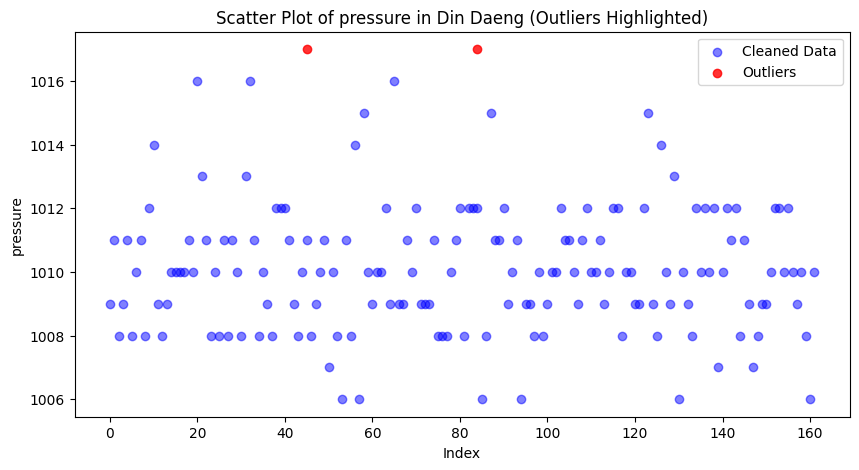

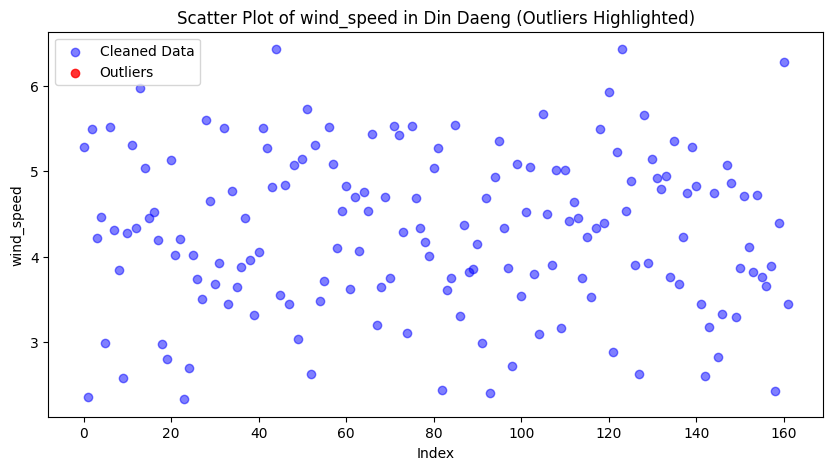

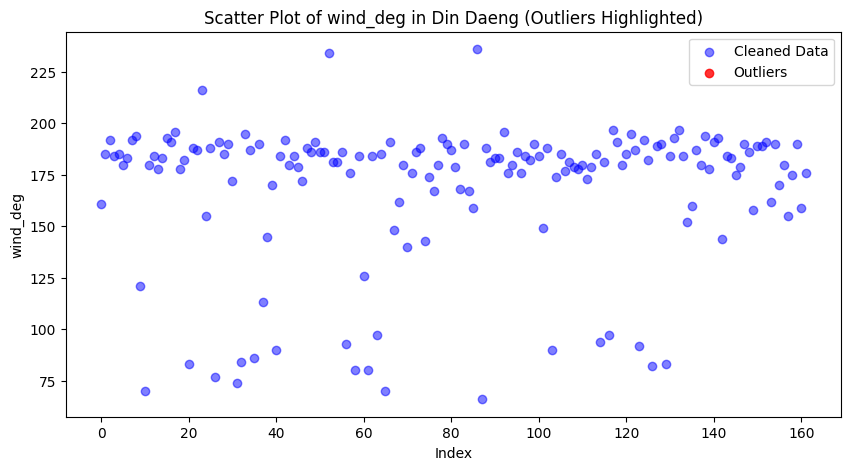

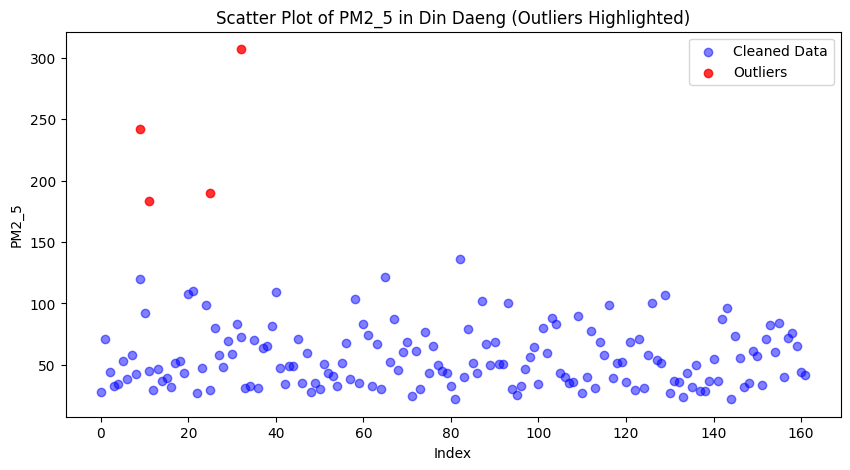

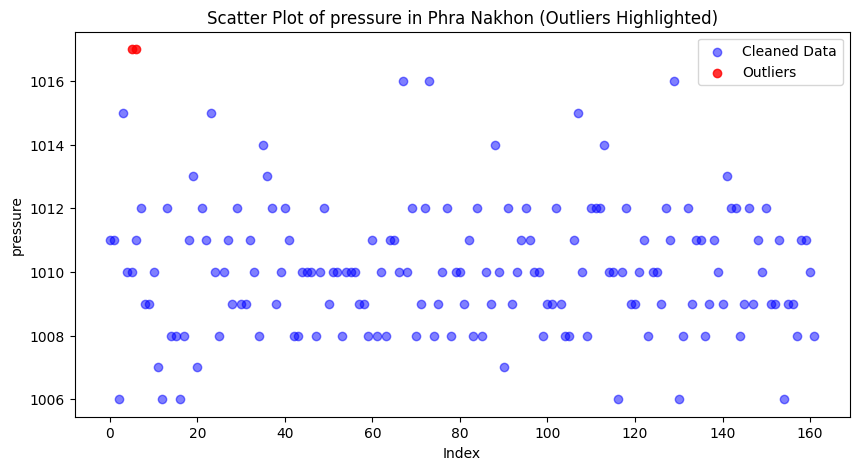

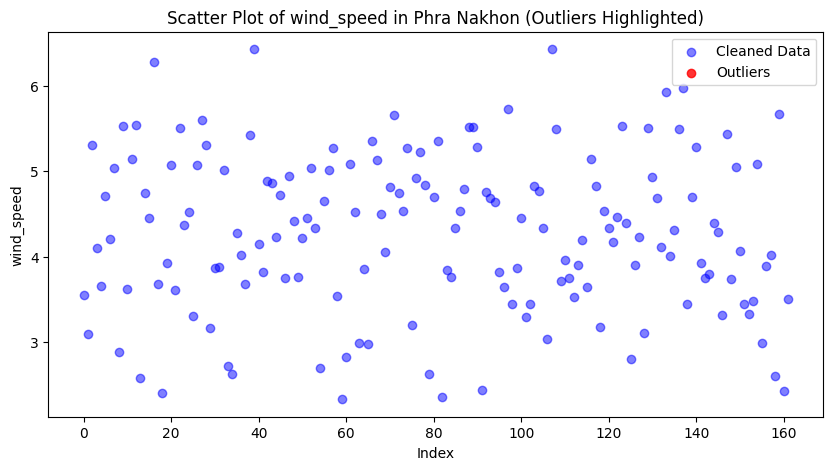

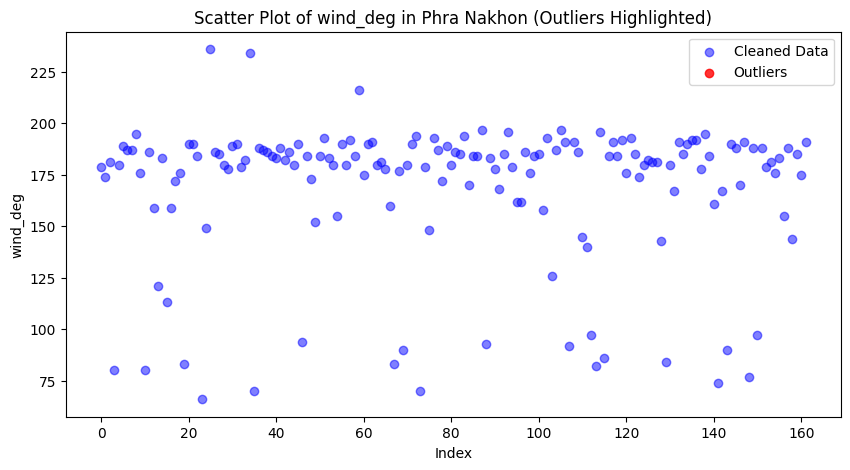

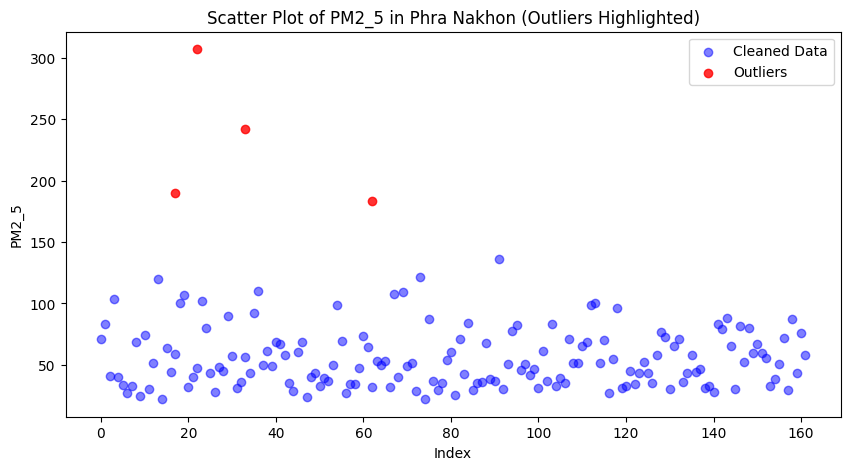

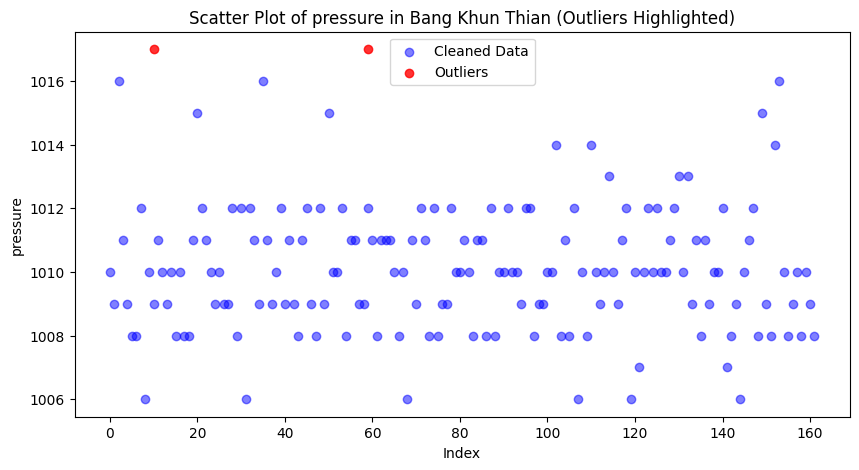

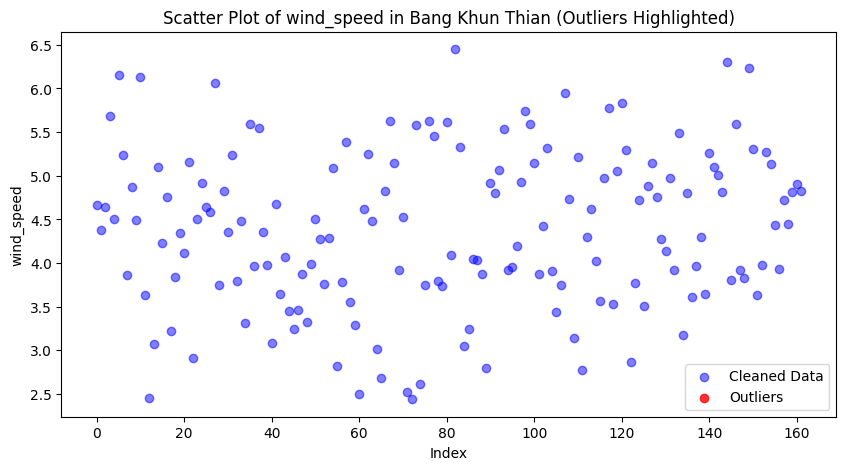

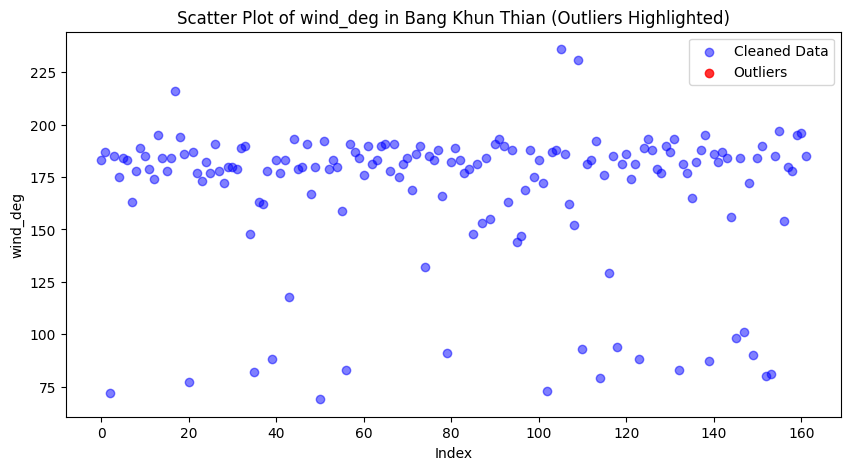

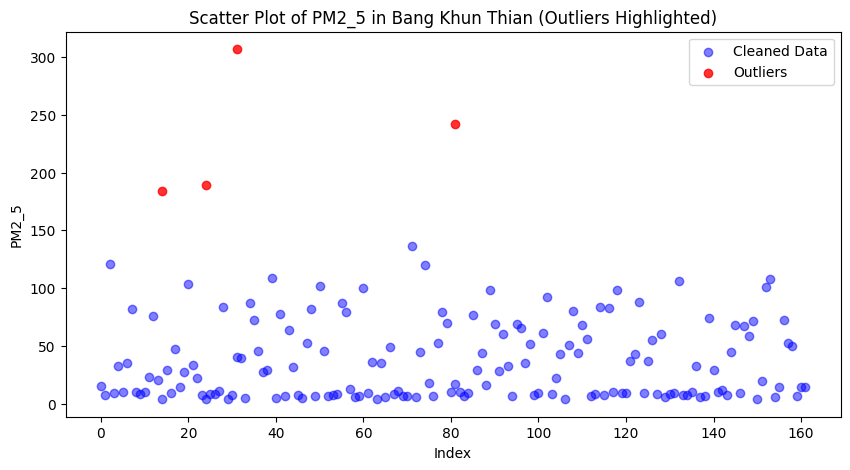

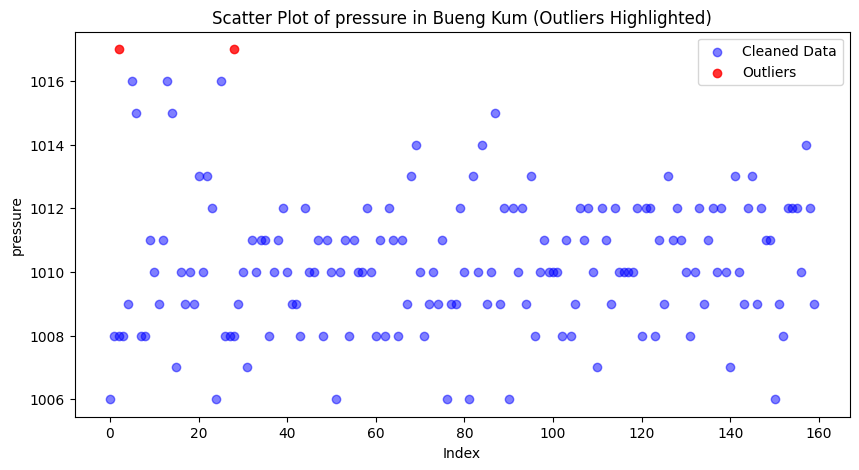

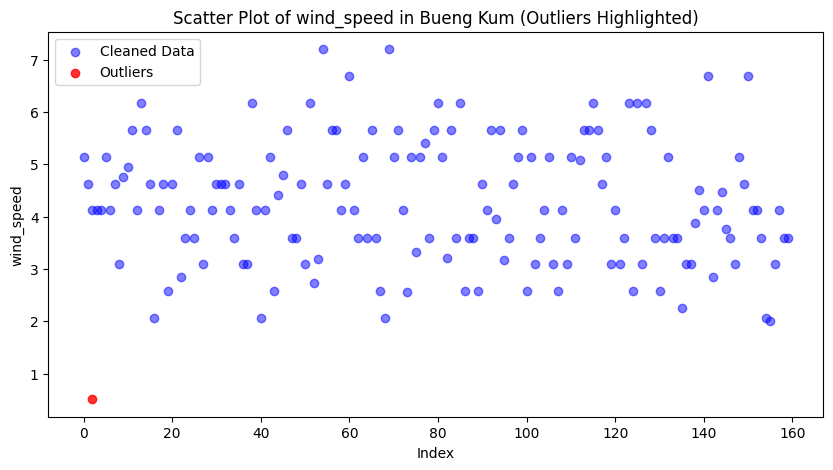

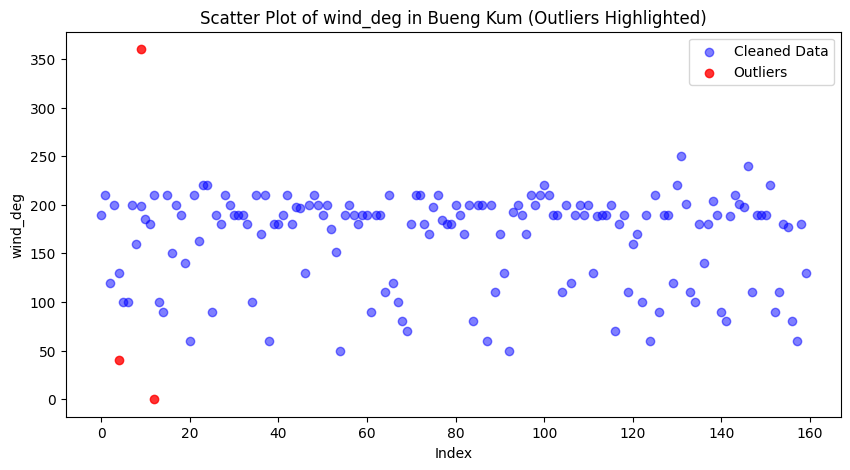

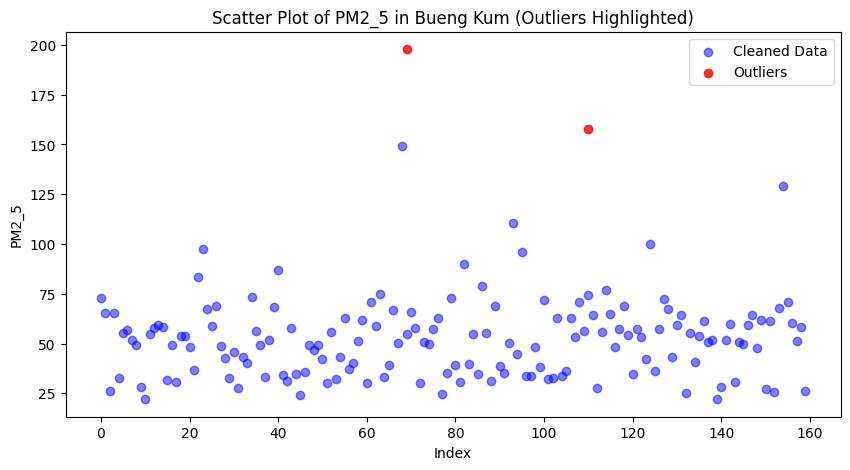

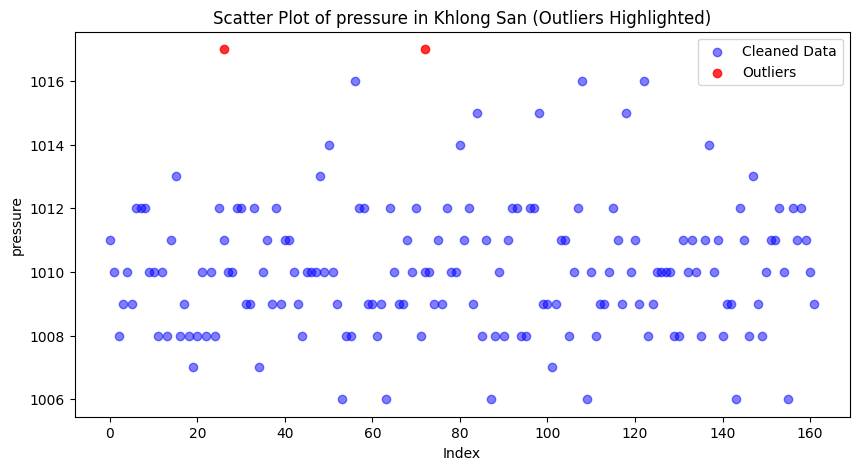

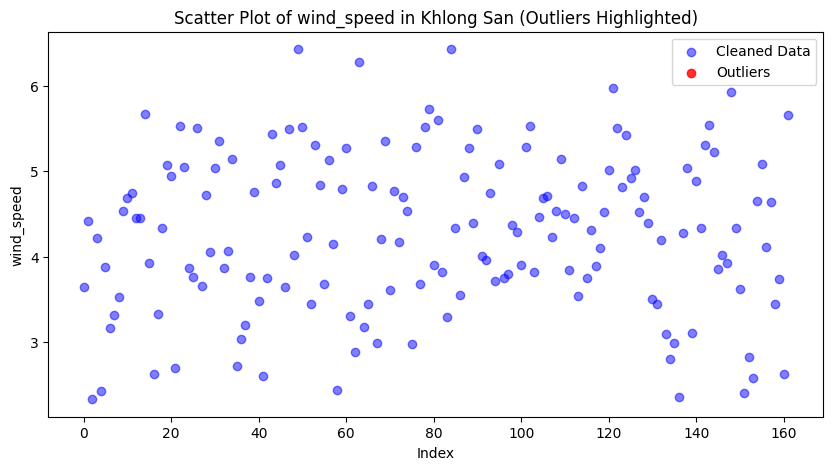

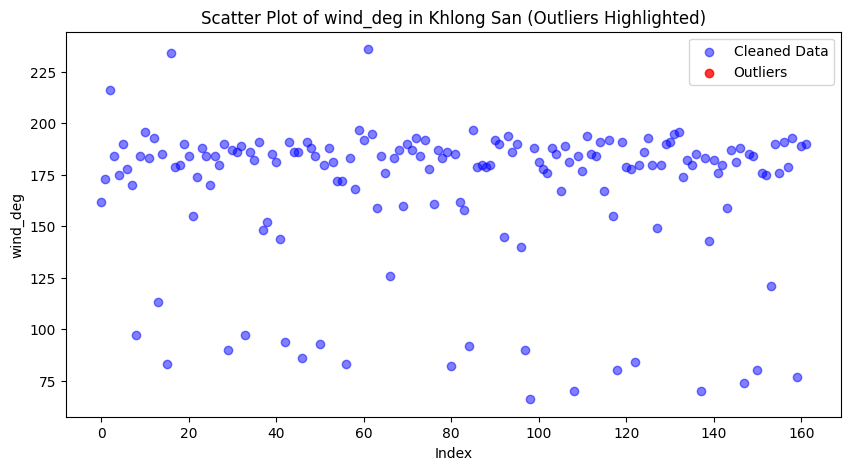

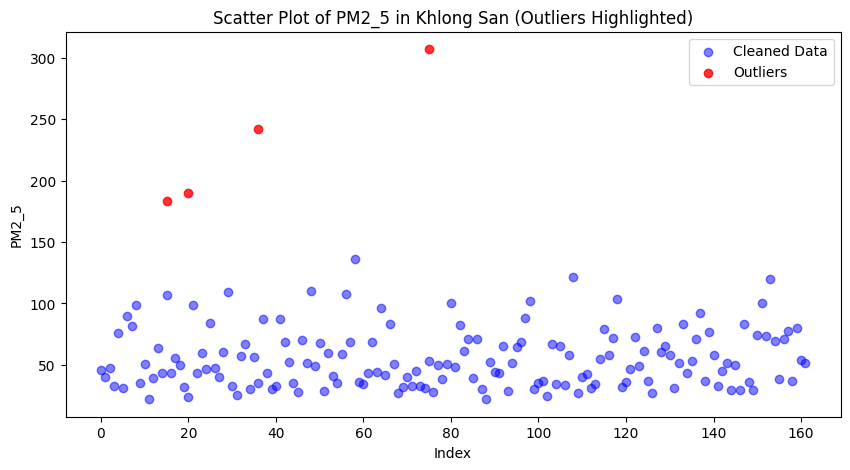

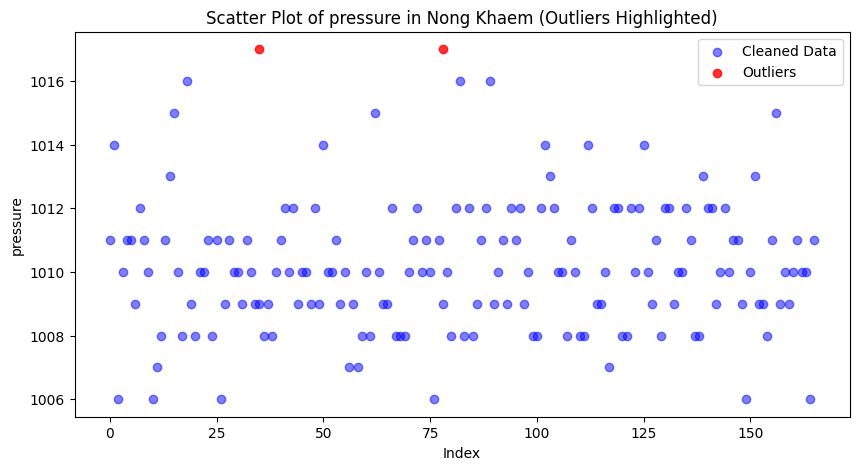

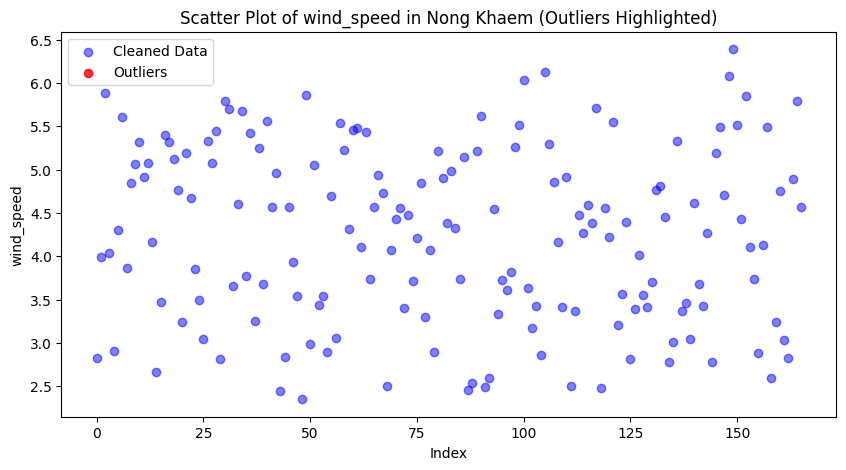

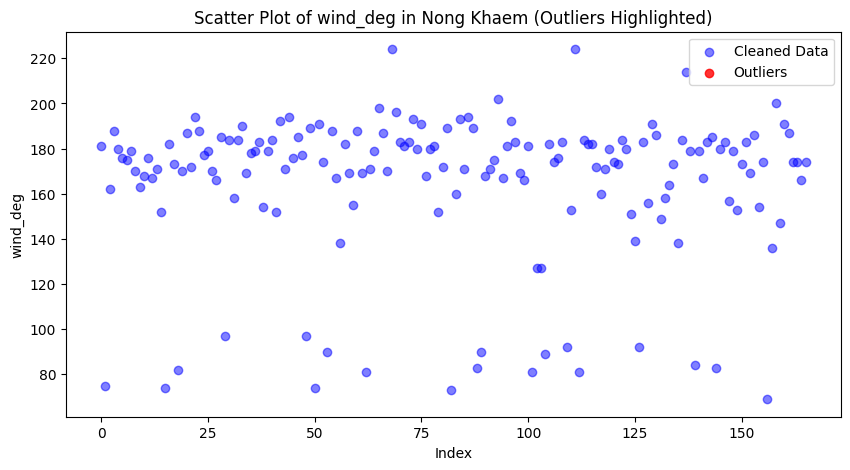

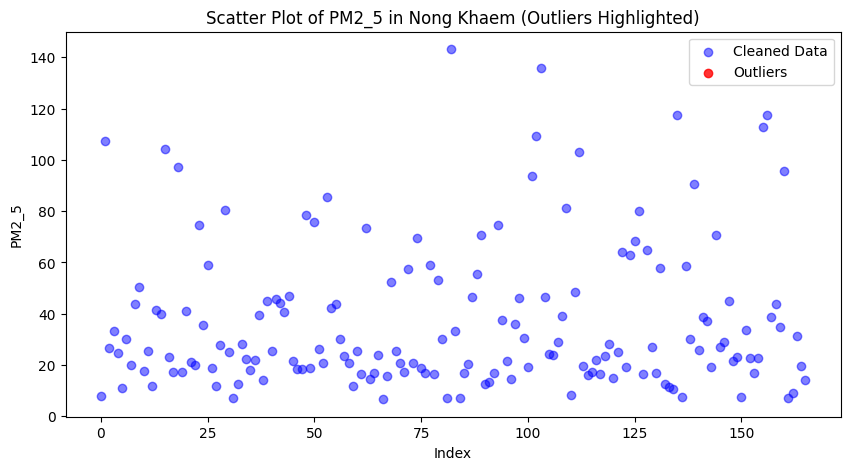

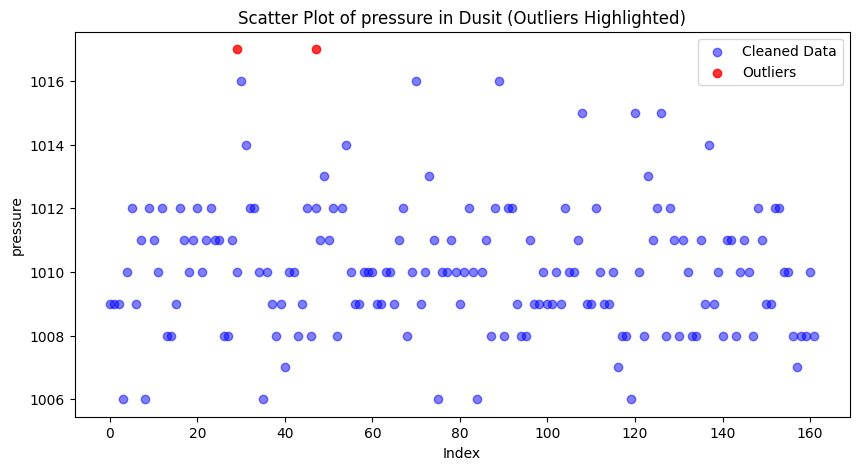

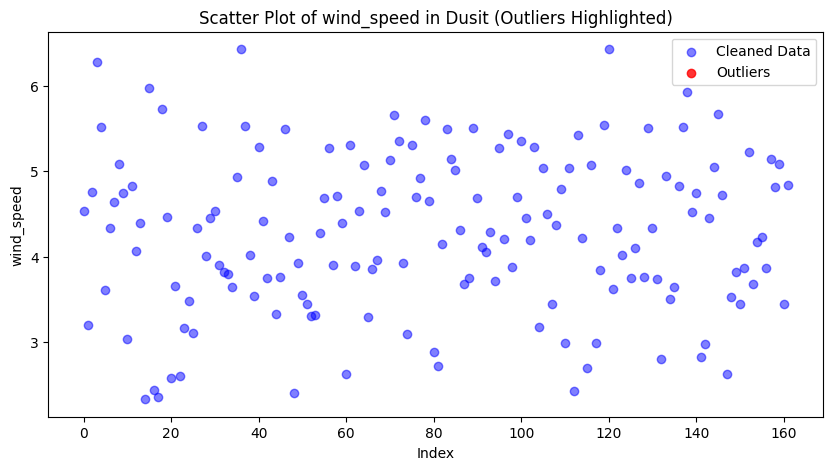

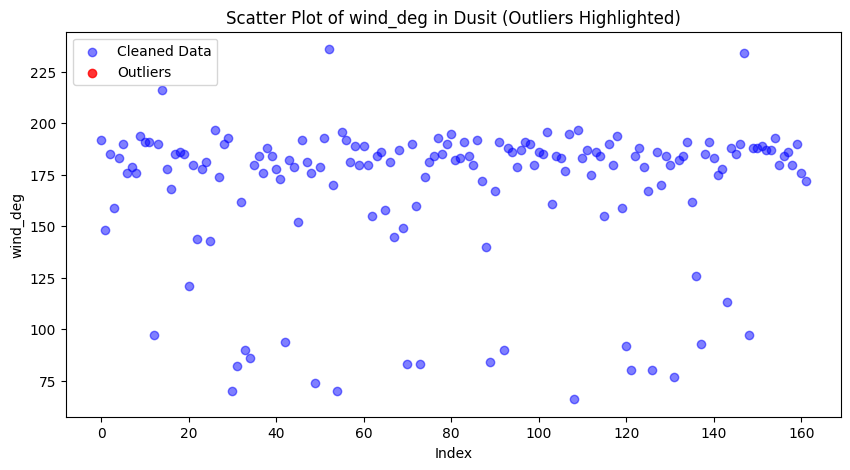

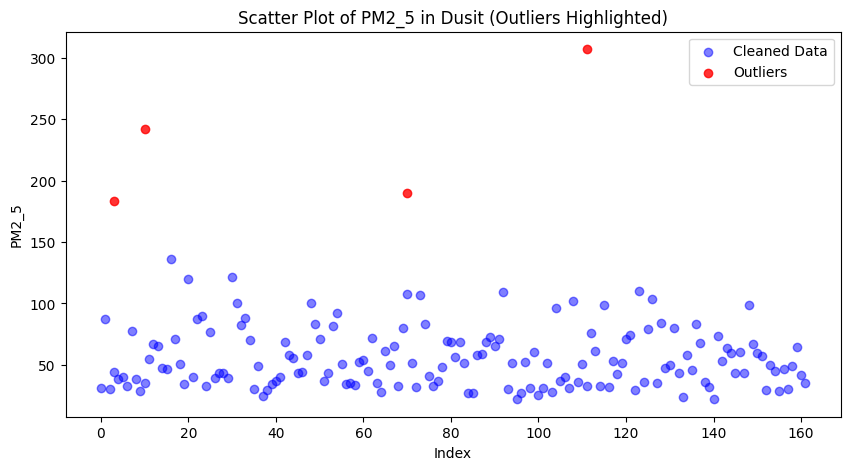

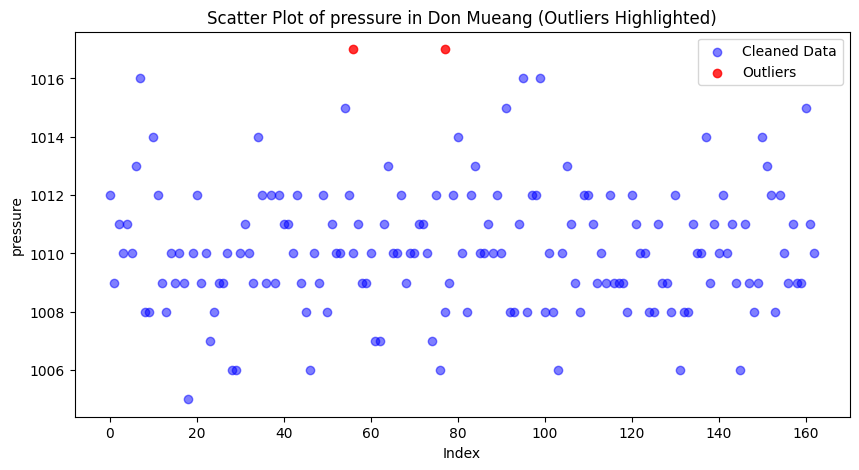

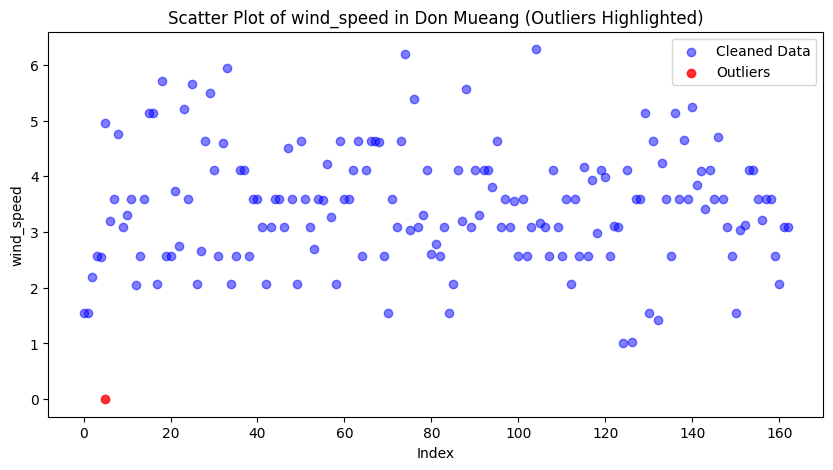

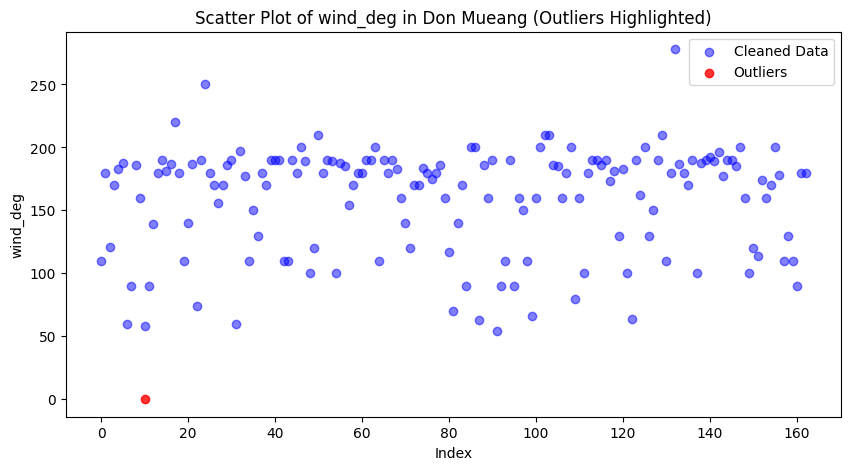

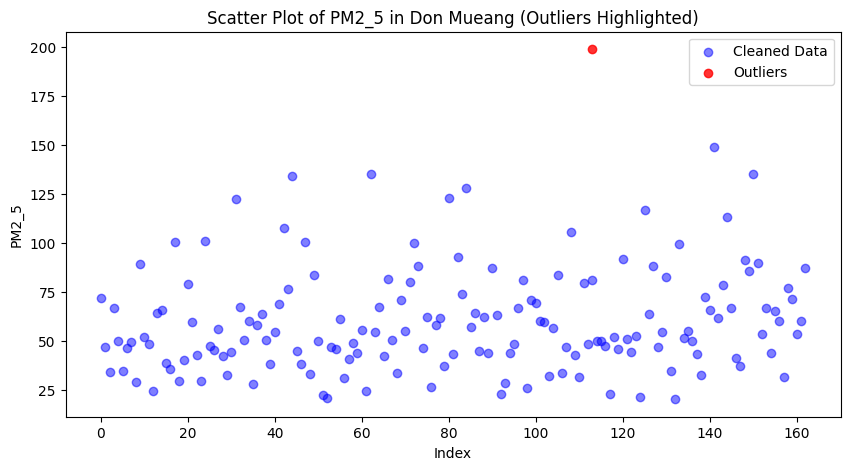

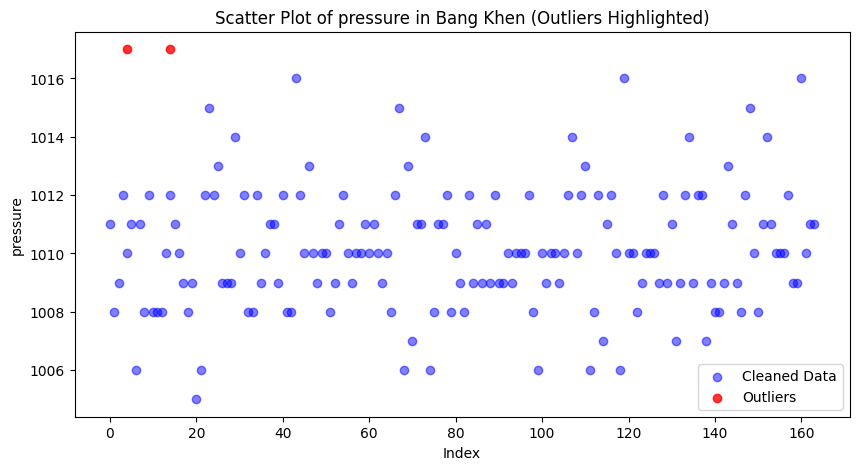

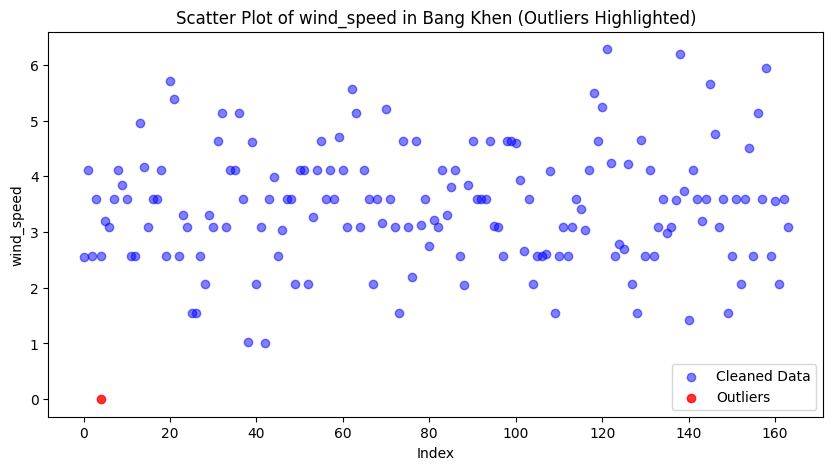

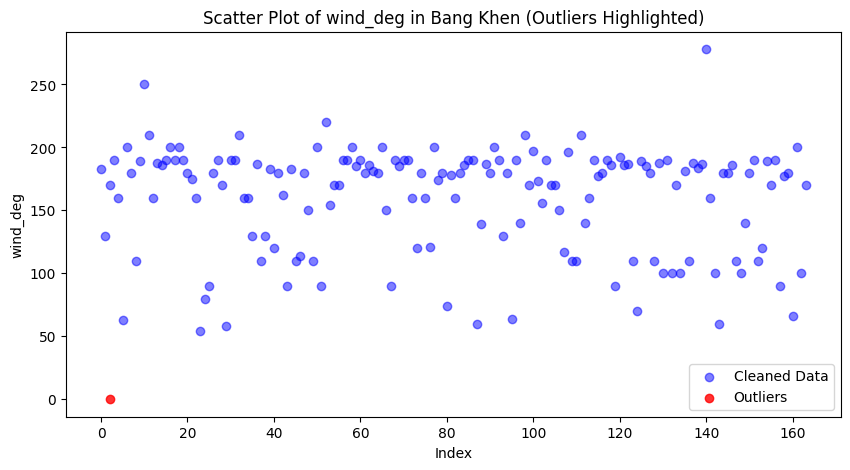

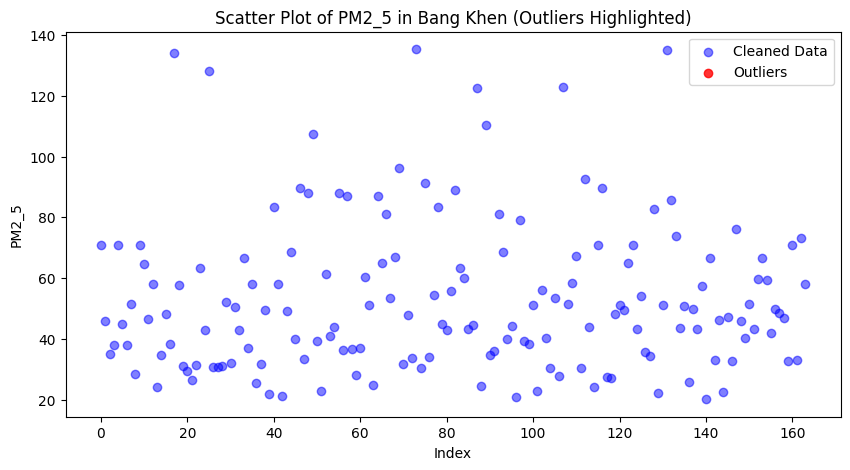

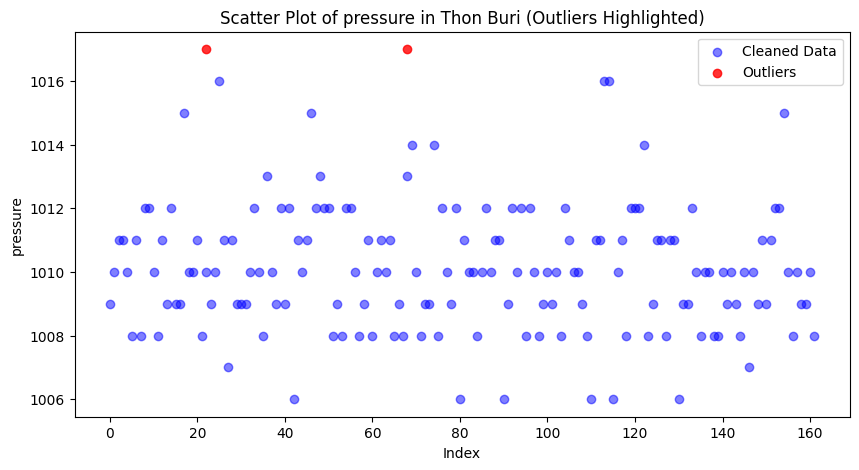

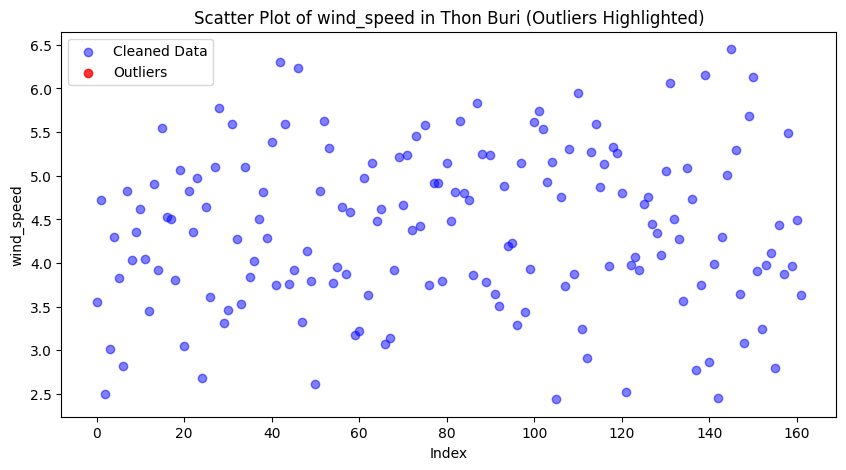

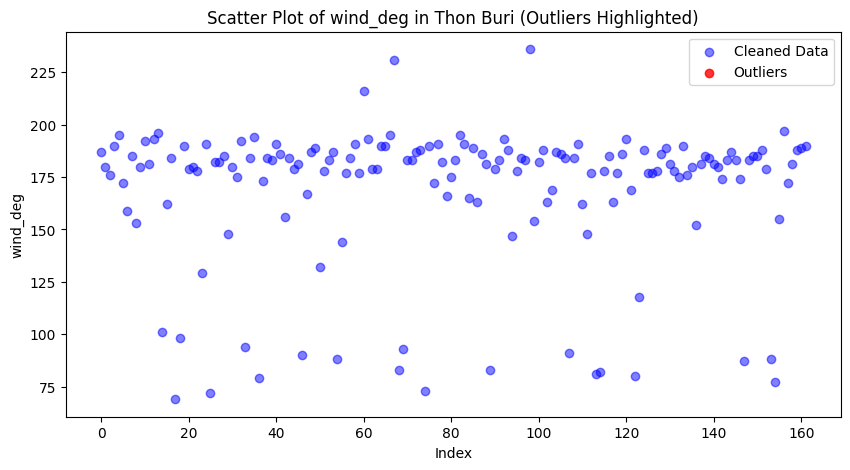

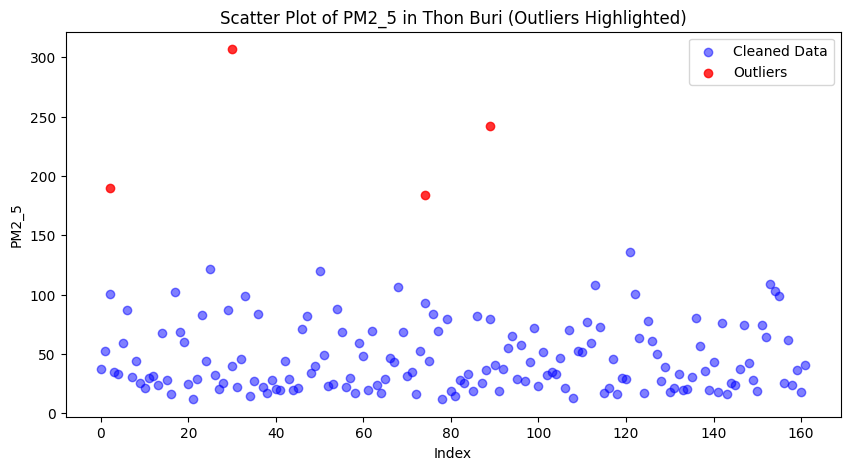

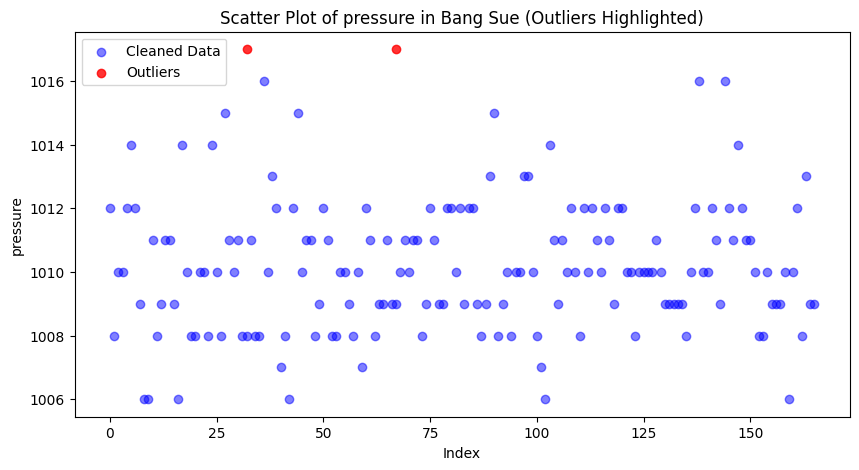

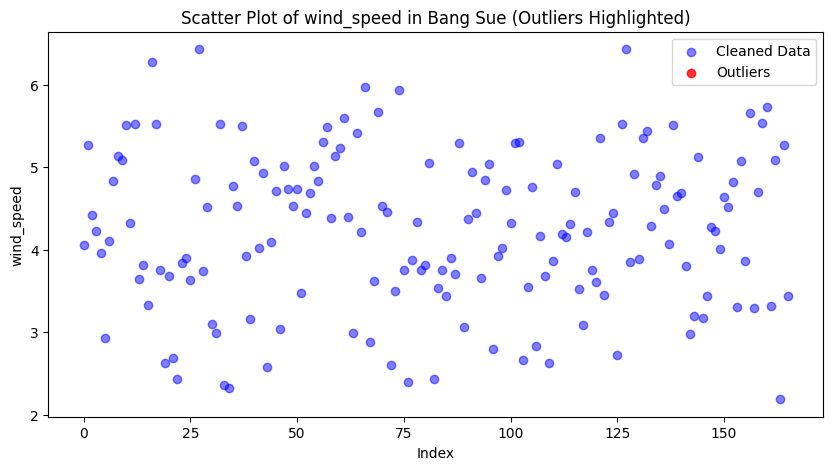

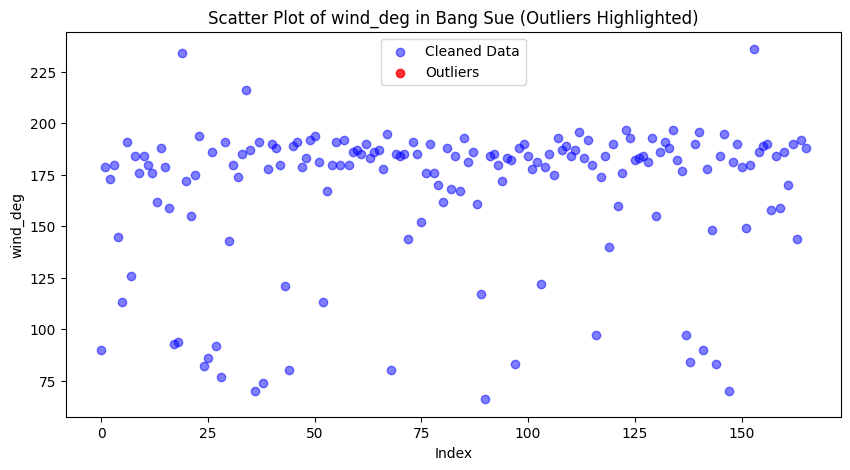

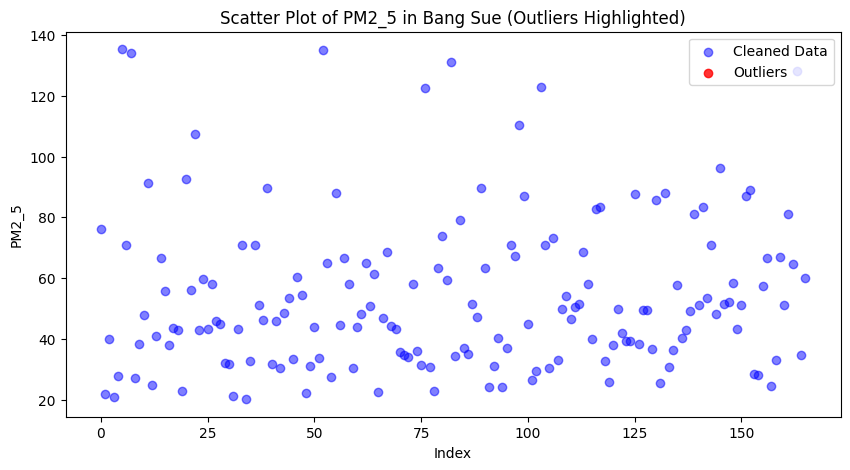

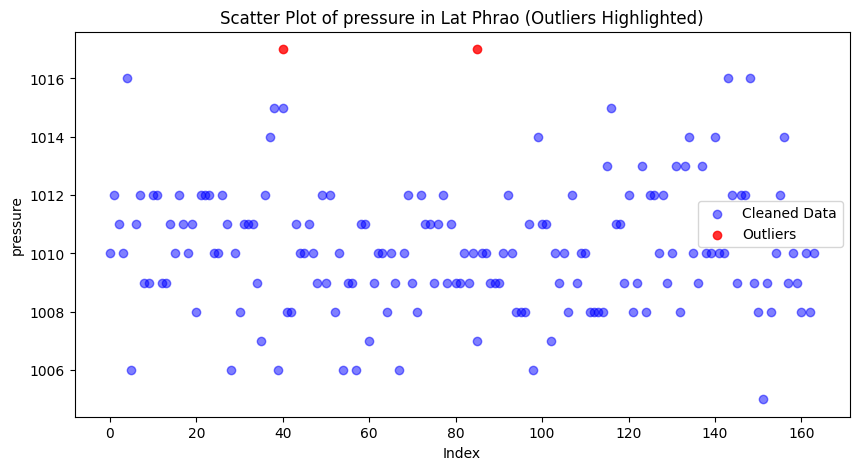

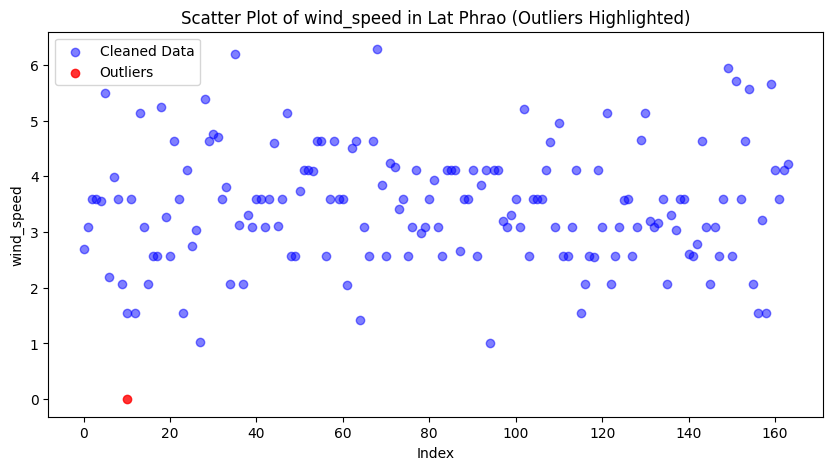

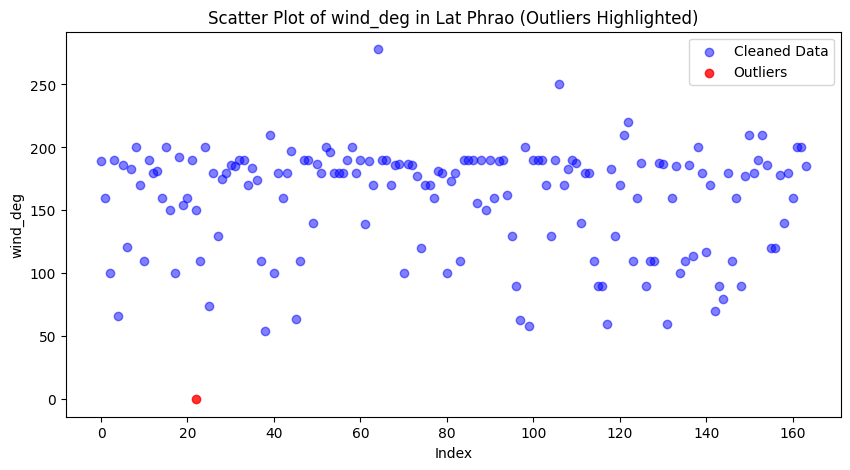

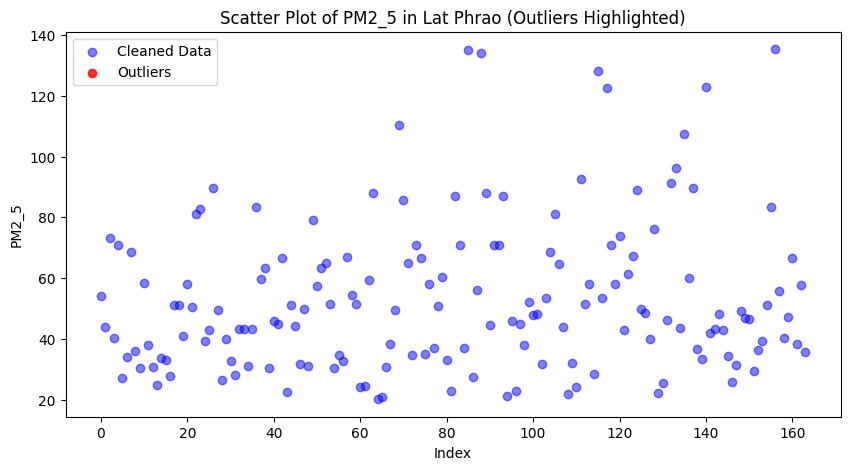

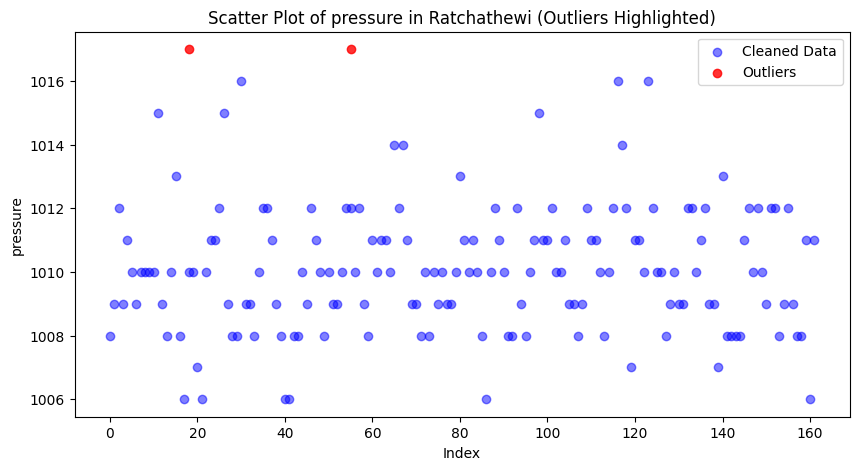

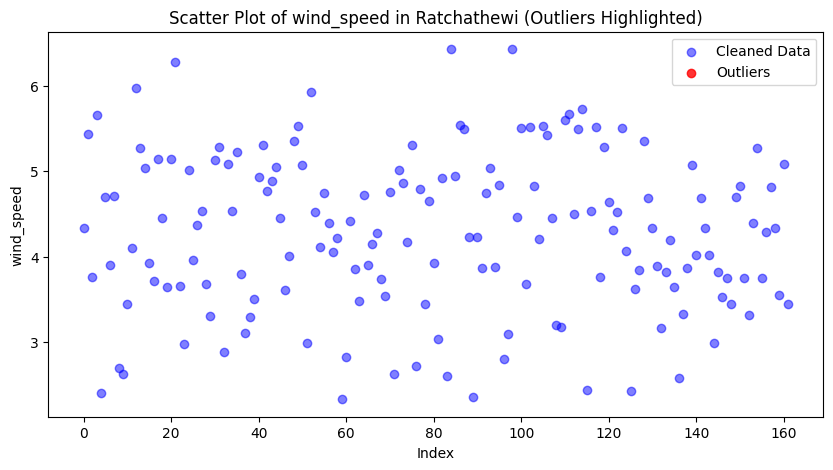

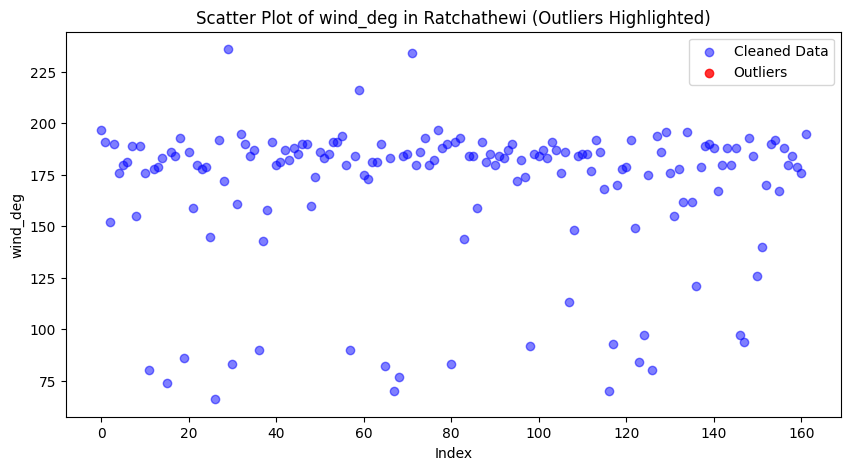

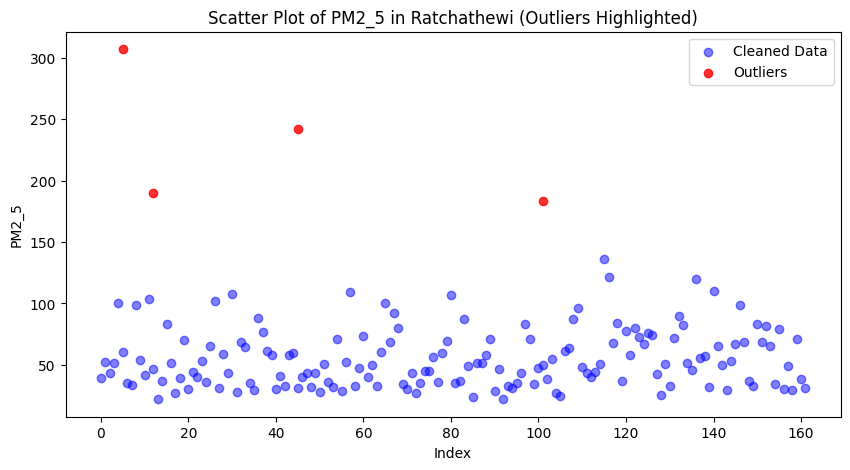

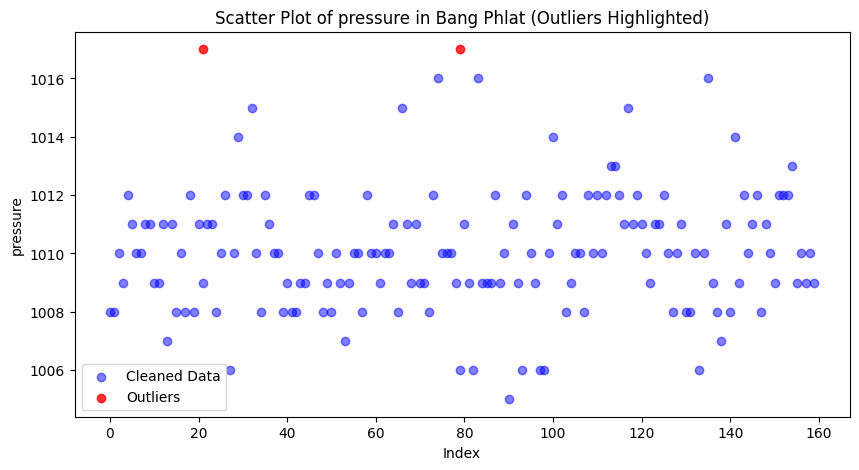

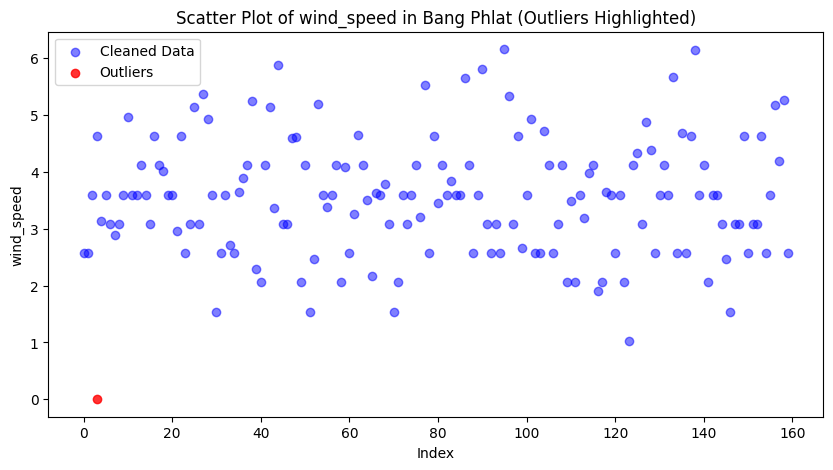

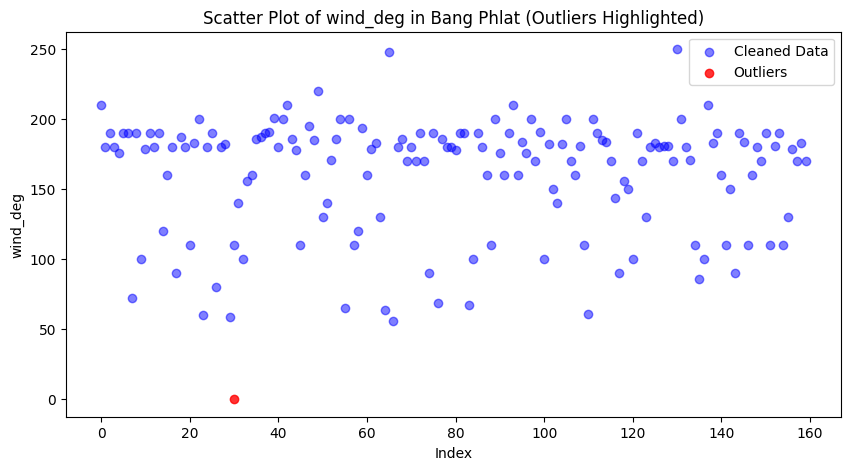

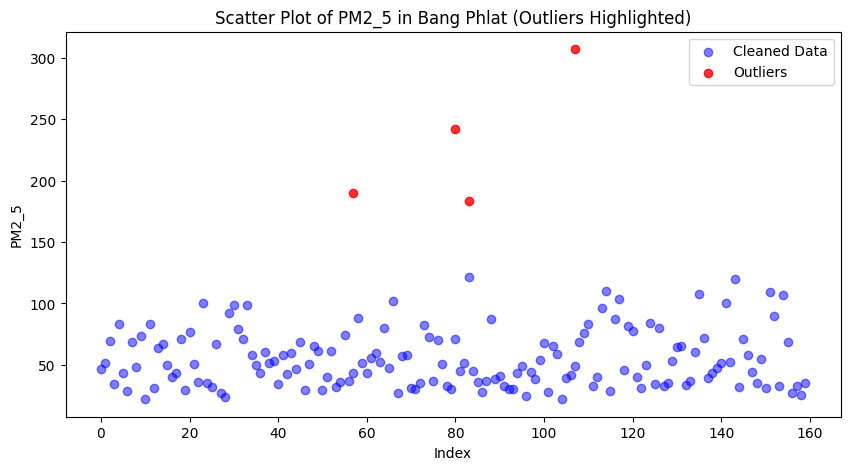

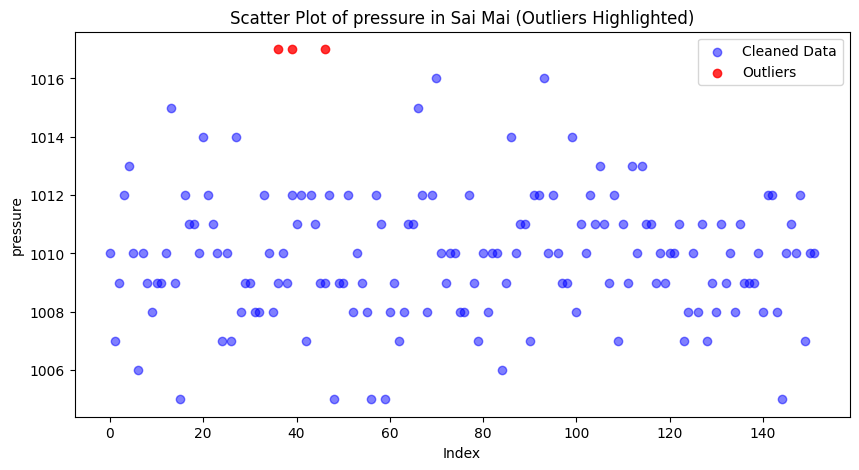

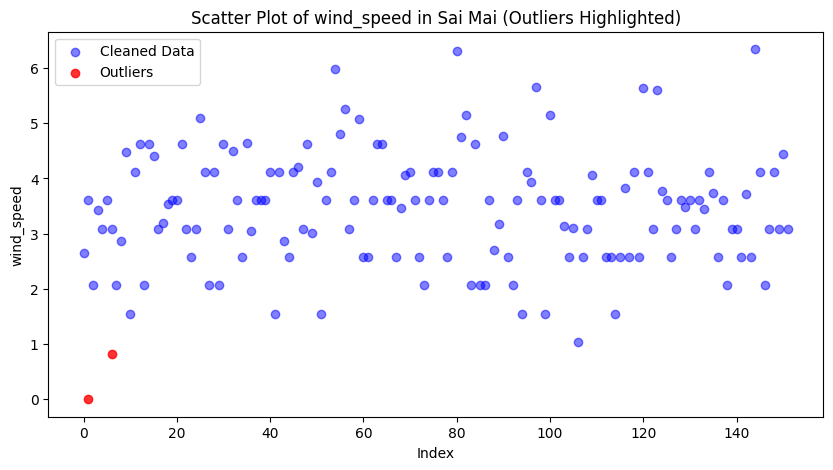

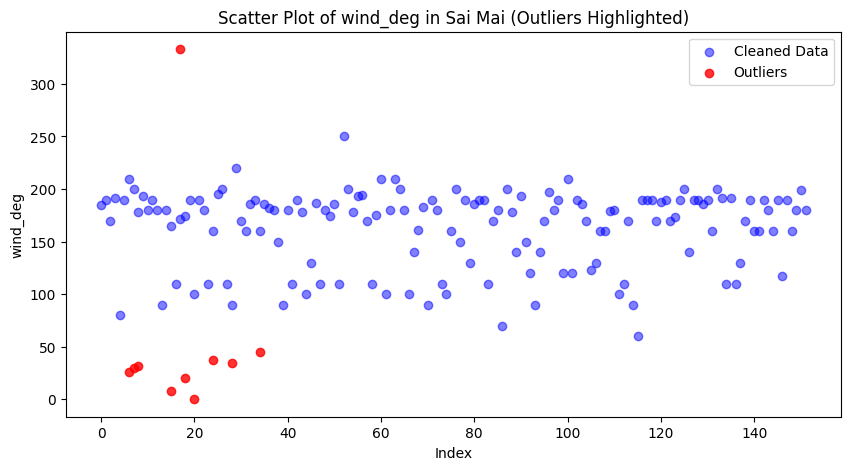

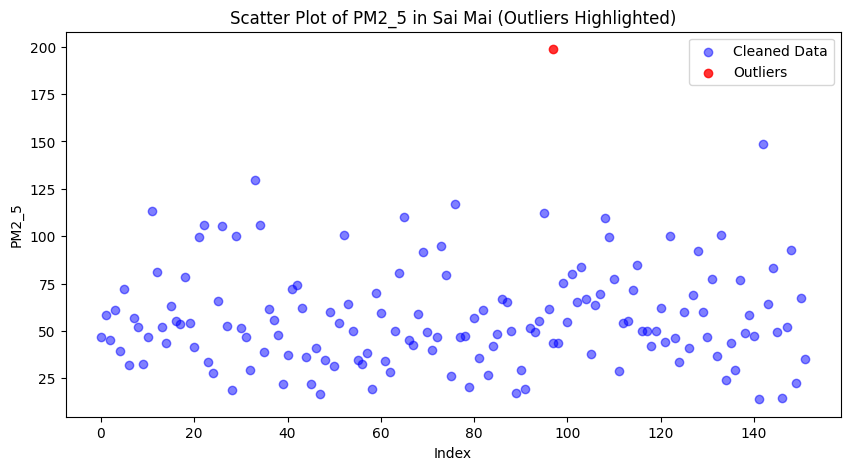

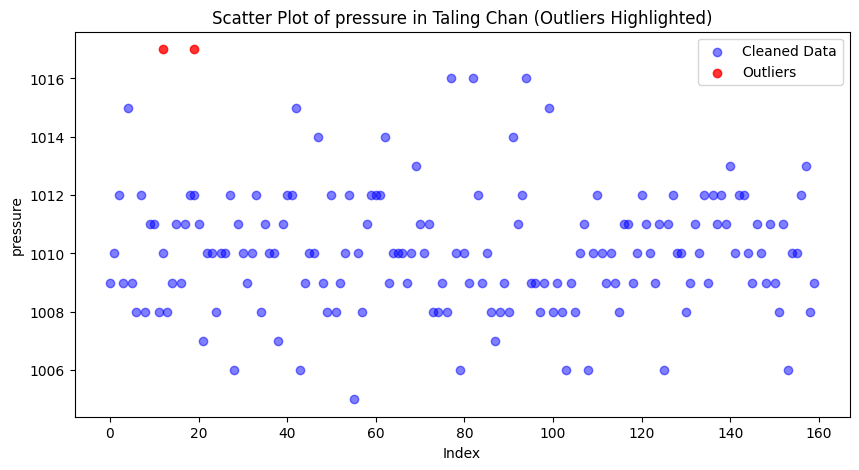

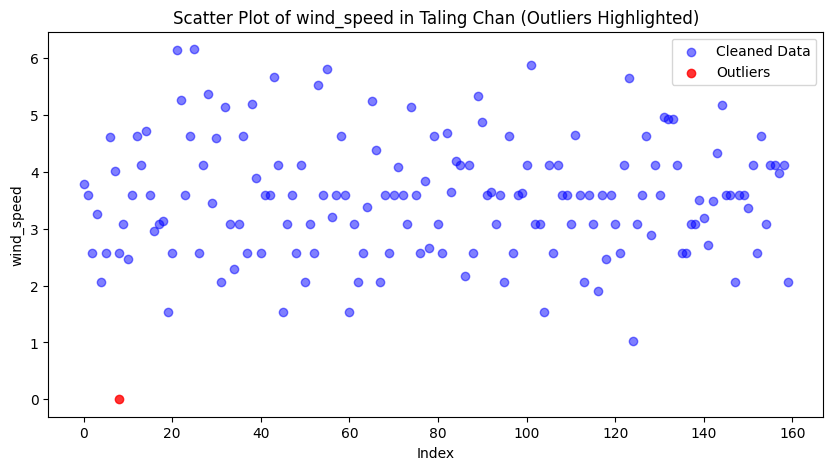

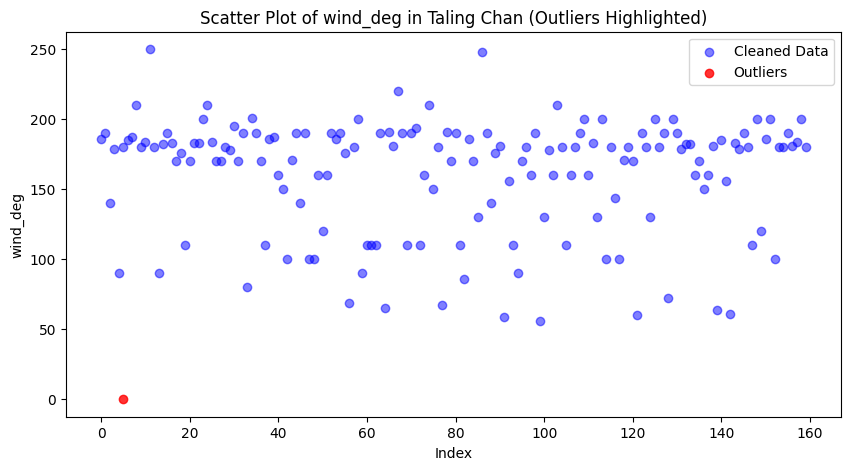

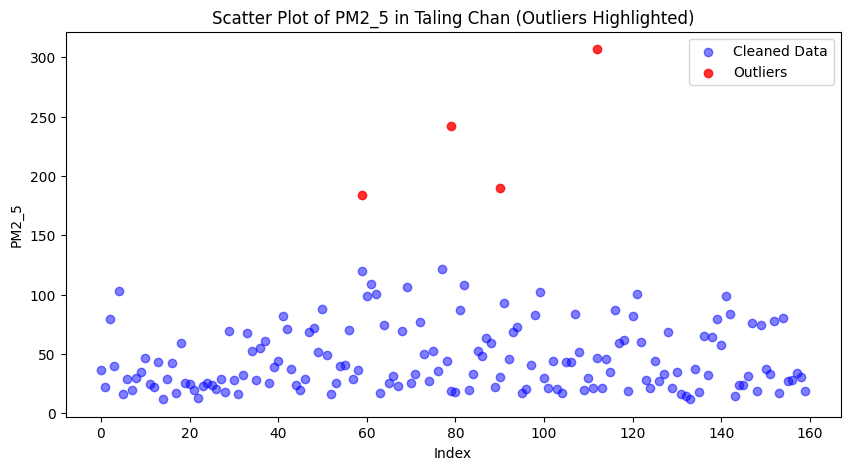

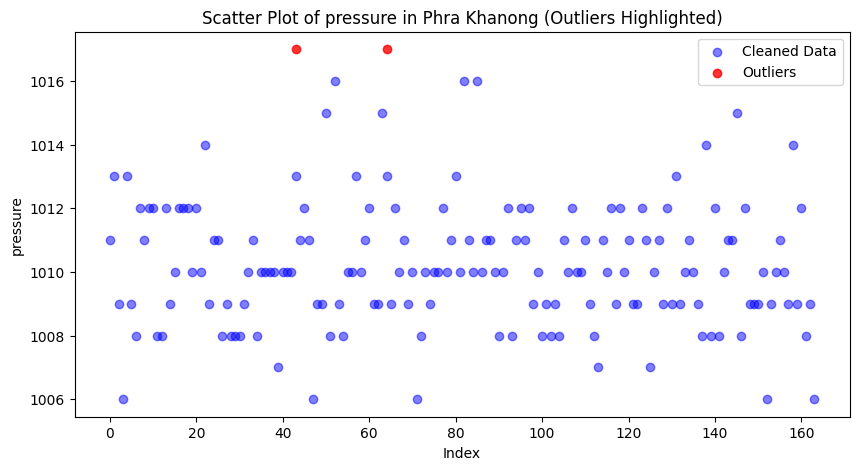

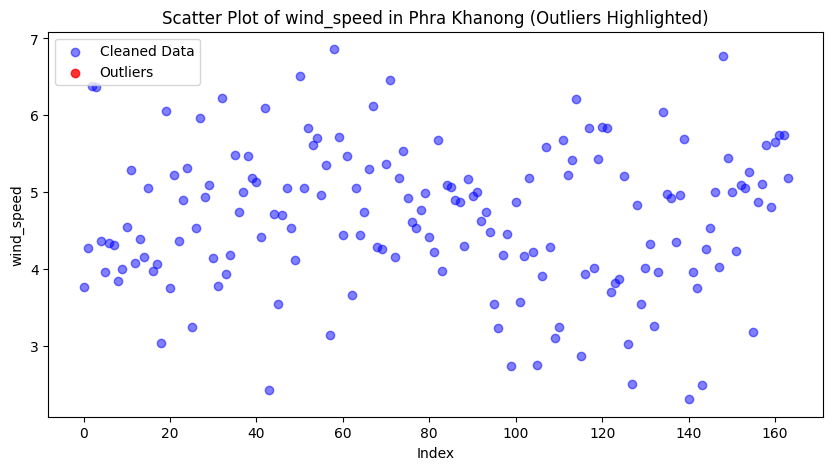

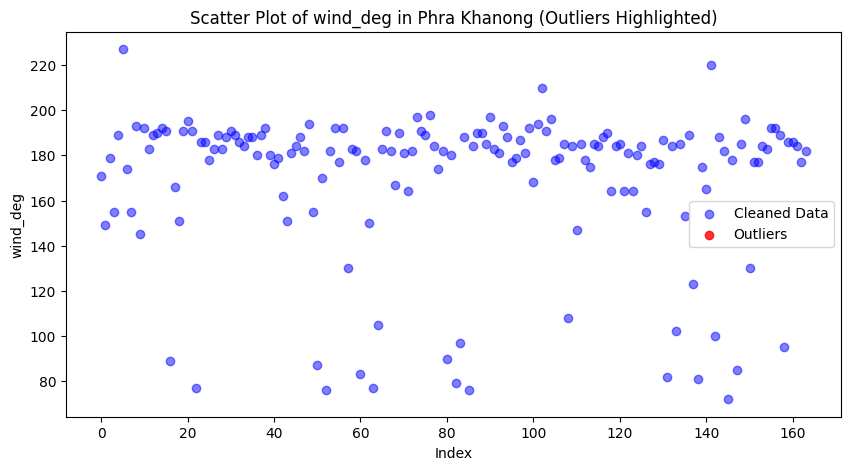

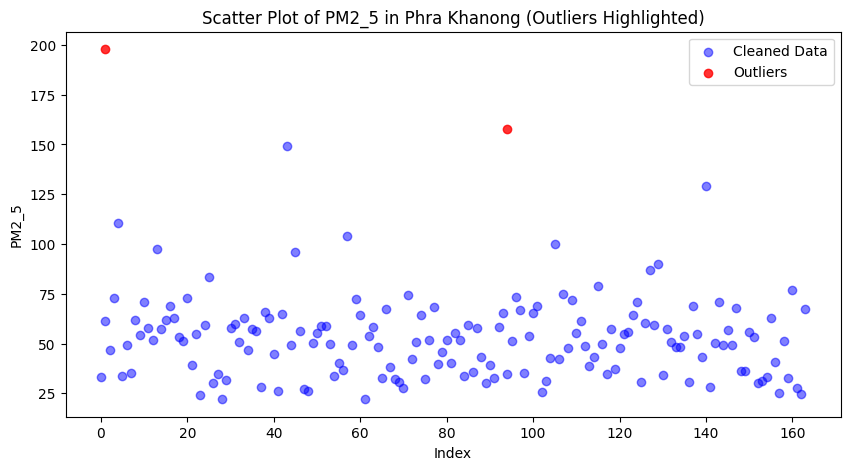

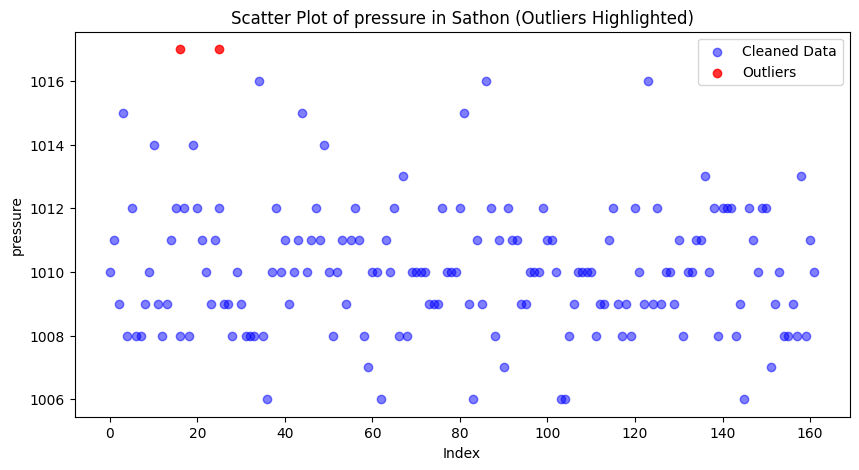

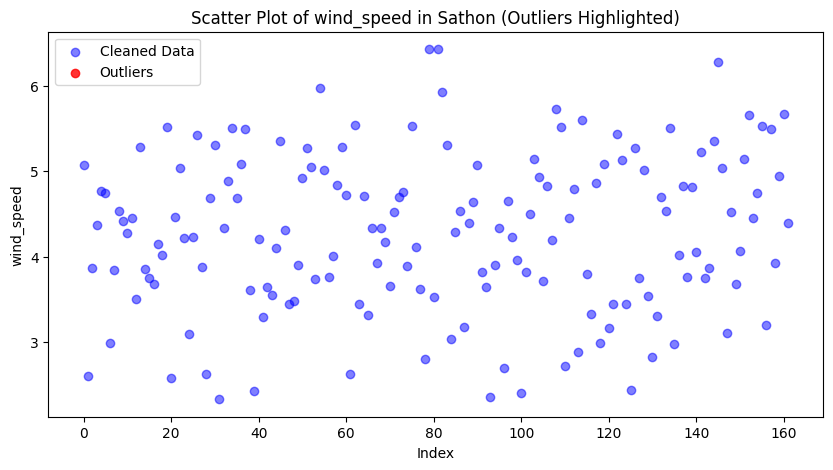

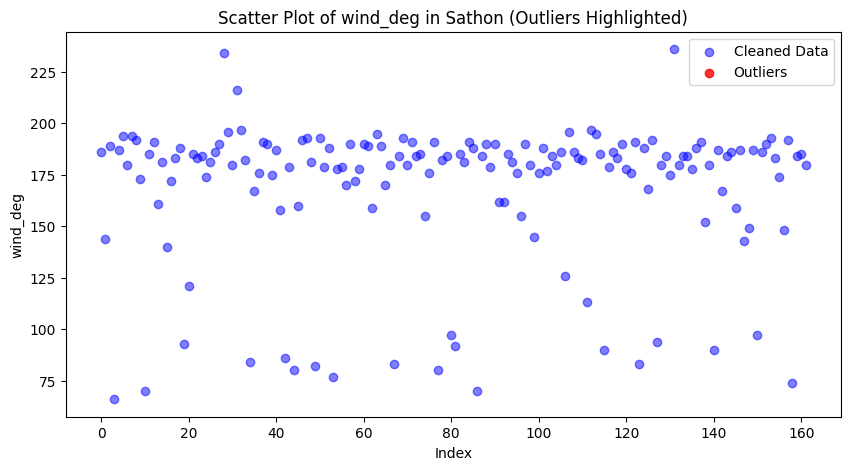

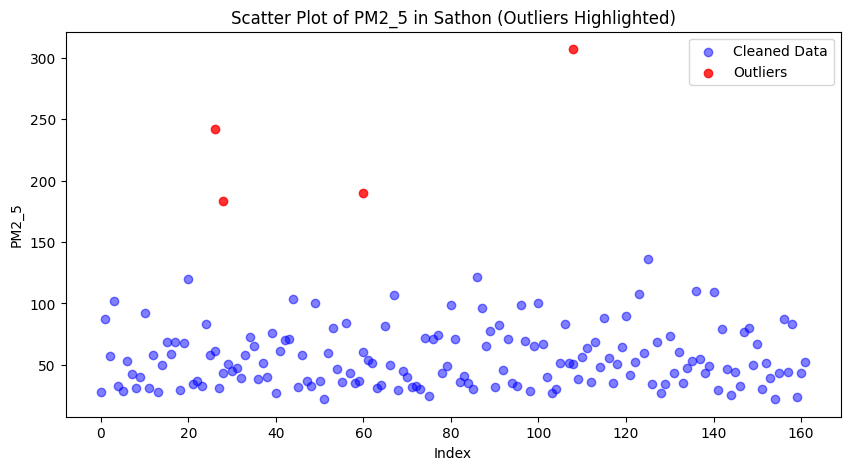

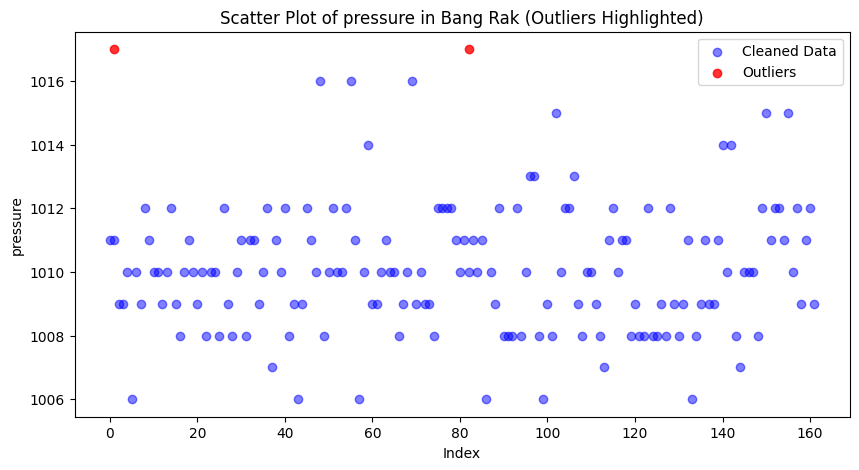

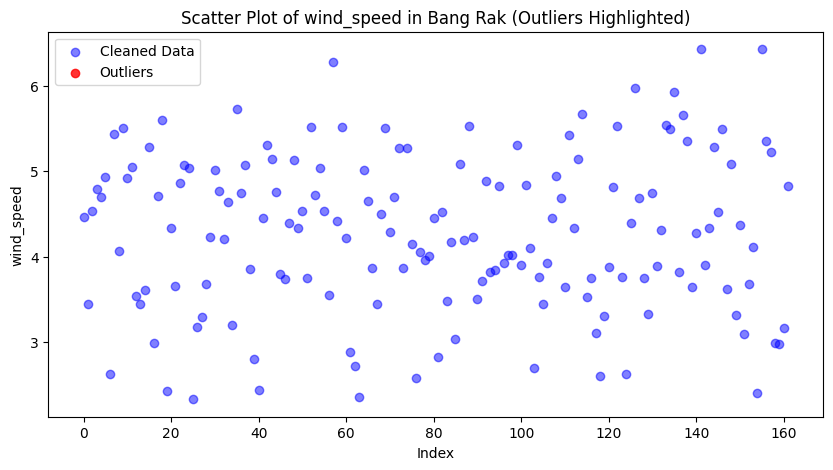

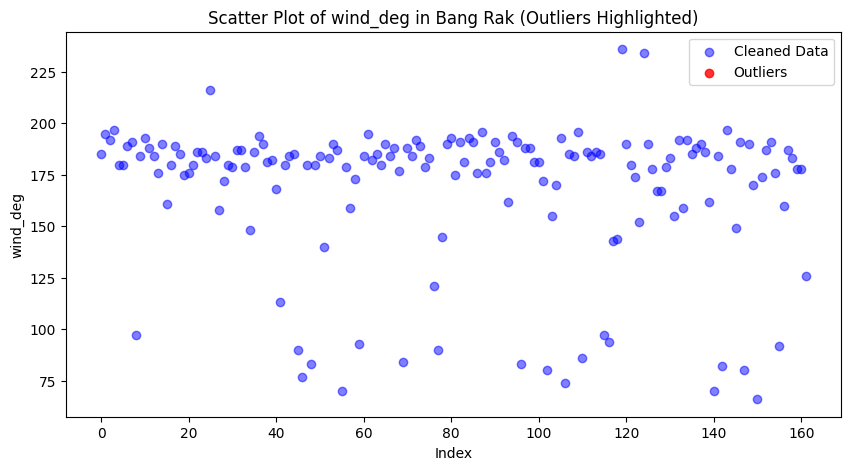

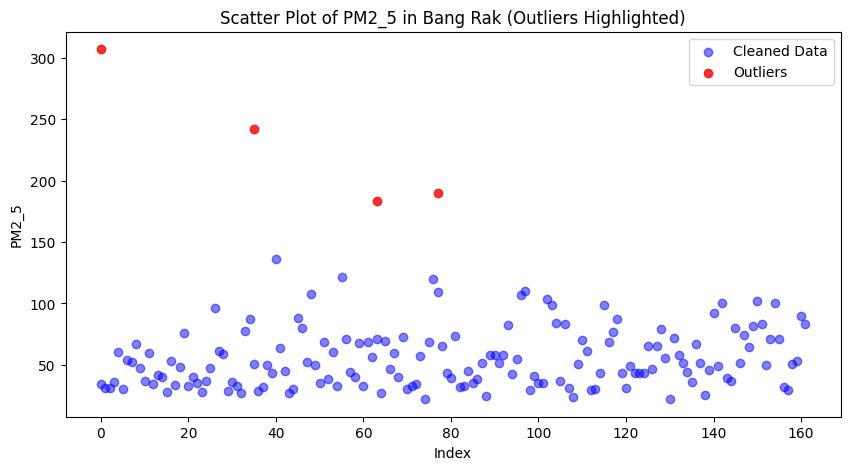

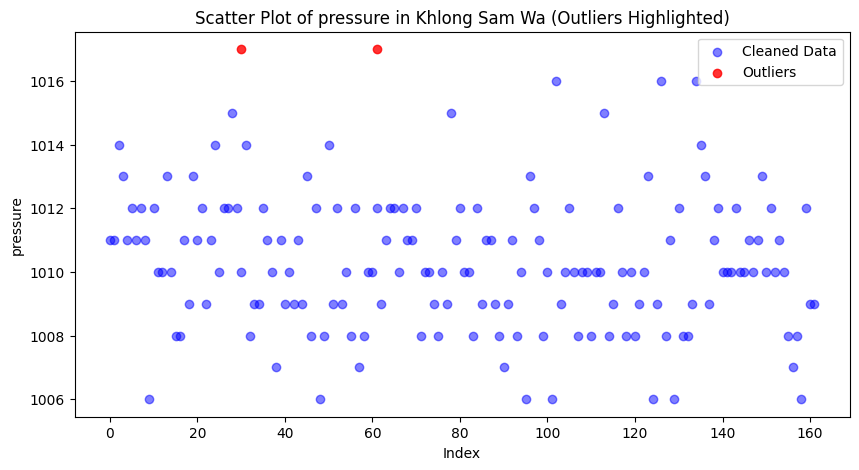

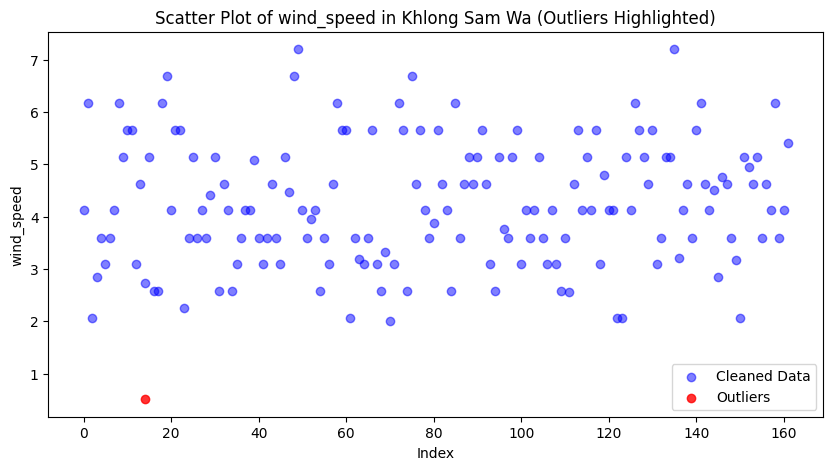

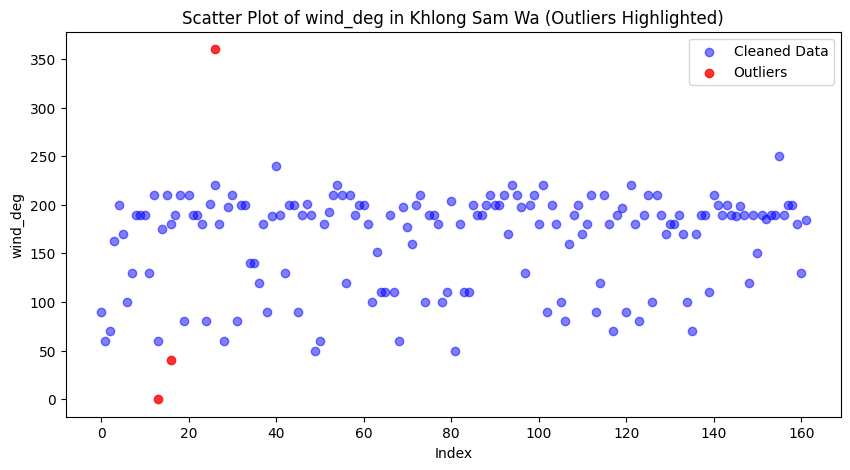

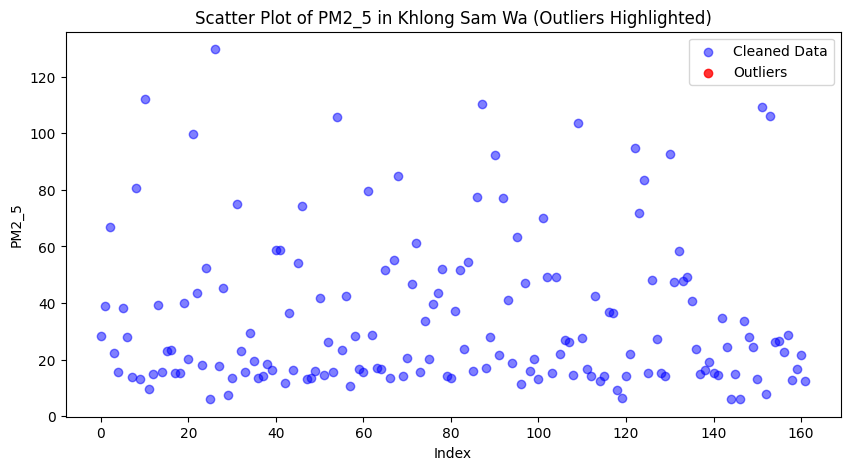

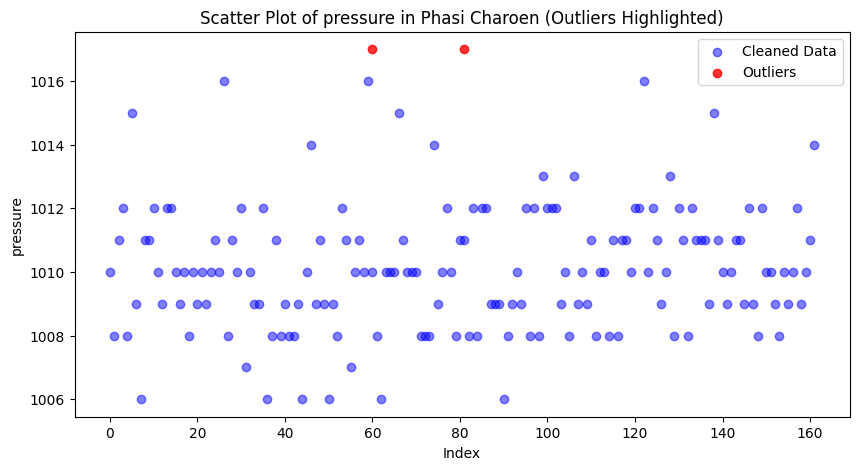

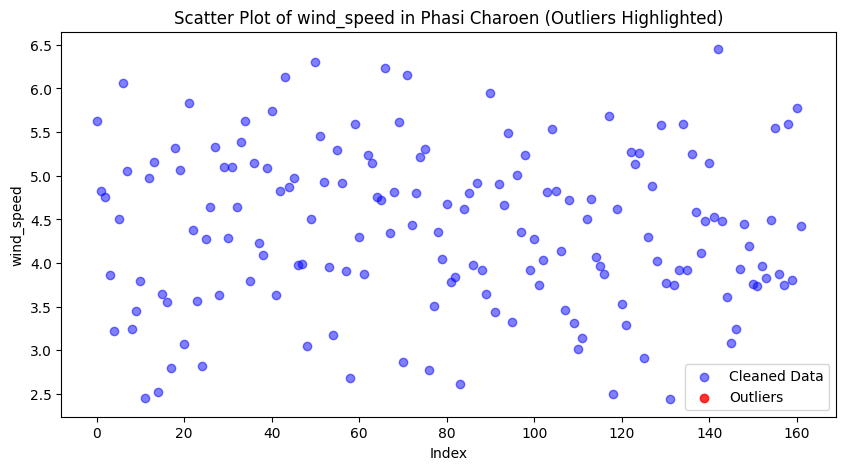

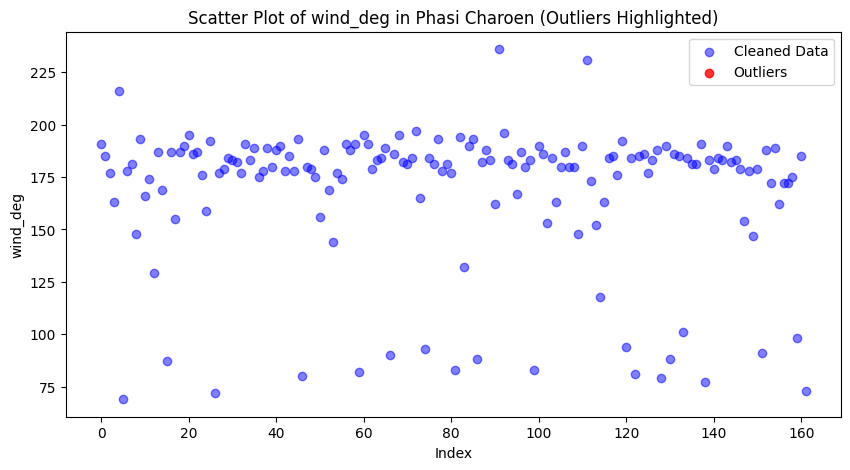

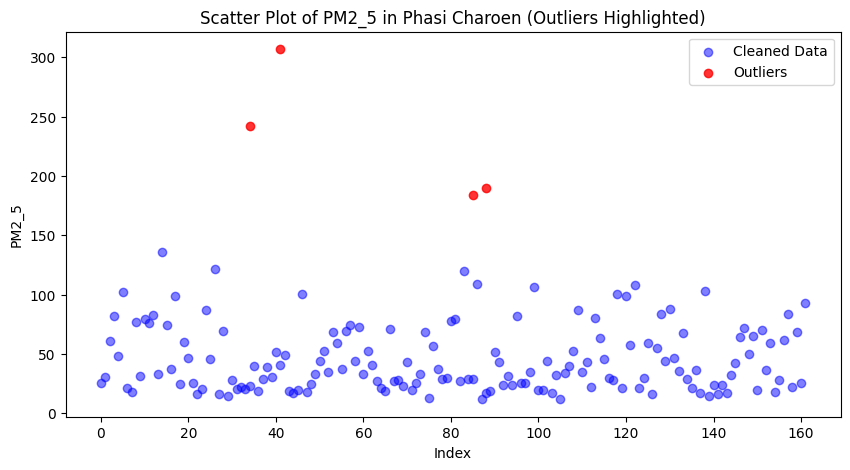

Data Cleaning Report:
Initial row count: 7224
Duplicate rows removed: 0
Initial Null Values:
[Row(district=0, timestamp=0, lat=0, lon=0, temp=0, feels_like=0, pressure=0, humidity=0, clouds=0, wind_speed=0, wind_deg=0, weather_main=0, weather_desc=0, PM2_5=0, FormattedDateTime=0)]
Final row count: 6971
Final Null Values:
[Row(district=0, timestamp=0, lat=0, lon=0, temp=0, feels_like=0, pressure=0, humidity=0, clouds=0, wind_speed=0, wind_deg=0, weather_main=0, weather_desc=0, PM2_5=0, FormattedDateTime=0)]
Data cleaning complete. Saved to cleaned_weather_data.csv


In [18]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, stddev, count, when,udf
from pyspark.sql.types import StringType
import matplotlib.pyplot as plt
import pandas as pd

from datetime import datetime
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType, IntegerType

def format_timestamp(timestamp_int):
    timestamp_obj = datetime.fromtimestamp(timestamp_int)
    formatted_timestamp = timestamp_obj.strftime('%Y-%m-%d %I:%M:%S %p')
    return formatted_timestamp


# Initialize Spark session
spark = SparkSession.builder.appName("DataCleaning").getOrCreate()

# Load CSV file
data_path = "weather_data.csv"
df = spark.read.csv(data_path, header=True, inferSchema=True)

format_timestamp_udf = udf(format_timestamp, StringType())
df = df.withColumn('FormattedDateTime', format_timestamp_udf(col('timestamp').cast(IntegerType())))

# Initial counts
initial_count = df.count()
initial_duplicates_df = df.exceptAll(df.dropDuplicates())
initial_duplicates = initial_duplicates_df.count()
initial_nulls = df.select([count(when(col(c).isNull(), 1)).alias(c) for c in df.columns]).collect()

# Print duplicate rows
if initial_duplicates > 0:
    print("Duplicate rows found:")
    initial_duplicates_df.show()

# Remove duplicates
df = df.dropDuplicates()
print(f"Row count after removing duplicates: {df.count()}")

# Handling null values (drop rows where all values are null)
df = df.dropna(how='all')
print(f"Row count after dropping null rows: {df.count()}")

# Print rows that had all null values before removal
null_rows_df = df.filter(
    sum(when(col(c).isNull(), 1).otherwise(0) for c in df.columns) == len(df.columns)
)
if null_rows_df.count() > 0:
    print("Rows with all null values:")
    null_rows_df.show()

# Fill missing values with mean for numerical columns
numeric_columns = [col_name for col_name, dtype in df.dtypes if dtype in ('int', 'double', 'float')]
exclude_columns = {"lat", "lon"}  # Exclude latitude and longitude from outlier detection
filtered_numeric_columns = [col for col in numeric_columns if col not in exclude_columns]

for col_name in numeric_columns:
    mean_value = df.select(mean(col(col_name))).collect()[0][0]
    if mean_value is not None:
        df = df.fillna({col_name: mean_value})

# Detect and remove outliers using IQR method
outlier_counts = {}
outlier_dfs = {}

def remove_outliers(df, column):
    stats = df.select(
        mean(col(column)).alias("mean"),
        stddev(col(column)).alias("stddev")
    ).collect()[0]
    if stats.stddev is not None:
        lower_bound = stats.mean - 3 * stats.stddev
        upper_bound = stats.mean + 3 * stats.stddev
        outliers_df = df.filter((col(column) < lower_bound) | (col(column) > upper_bound))
        outlier_counts[column] = outliers_df.count()
        if outlier_counts[column] > 0:
            outlier_dfs[column] = outliers_df.select("District", column).toPandas()
        return df.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))
    return df

for col_name in filtered_numeric_columns:
    df = remove_outliers(df, col_name)
    print(f"Row count after removing outliers from {col_name}: {df.count()}")

# Generate scatter plots for each column with outliers, ordered by district
for district in df.select("District").distinct().rdd.flatMap(lambda x: x).collect():
    district_df = df.filter(col("District") == district)
    for col_name in filtered_numeric_columns:
        if col_name in outlier_dfs:
            district_outliers = outlier_dfs[col_name]
            district_outliers = district_outliers[district_outliers["District"] == district]
            district_data = district_df.select(col_name).toPandas()

            plt.figure(figsize=(10, 5))
            plt.scatter(range(len(district_data)), district_data[col_name], label='Cleaned Data', color='blue', alpha=0.5)
            plt.scatter(district_outliers.index, district_outliers[col_name], label='Outliers', color='red', alpha=0.8)
            plt.xlabel("Index")
            plt.ylabel(col_name)
            plt.title(f"Scatter Plot of {col_name} in {district} (Outliers Highlighted)")
            plt.legend()
            plt.show()

# Final counts
final_count = df.count()
final_nulls = df.select([count(when(col(c).isNull(), 1)).alias(c) for c in df.columns]).collect()

# Order by District before saving
df = df.orderBy("District", "FormattedDateTime")

# Save cleaned data to CSV
output_path = "cleaned_weather_data.csv"
df.write.csv(output_path, header=True, mode='overwrite')

# Print report
print("Data Cleaning Report:")
print(f"Initial row count: {initial_count}")
print(f"Duplicate rows removed: {initial_duplicates}")
print("Initial Null Values:")
print(initial_nulls)
print(f"Final row count: {final_count}")
print("Final Null Values:")
print(final_nulls)
print("Data cleaning complete. Saved to", output_path)

# Stop Spark session
spark.stop()
